#Trend Analysis - Agritech Domain
- **Descrizione**: L'obiettivo principale di questa iniziativa è sviluppare un modello predittivo in grado di stimare con precisione il numero di insetti catturati da una o più trappole, utilizzando dati ambientali giornalieri relativi alla temperatura e all'umidità.

- **Dati**: Il dataset fornito è suddiviso in più file Excel, ciascuno dei quali contiene i dati raccolti da sensori installati nelle città di Imola e Cicalino.

- **Task**:
  1.   *Regressione* : prevedere il numero totale di insetti catturati in un determinato periodo
  2.   *Classificazione* : identificazione della presenza di nuove catture in un determinato periodo



Per i motivi descritti nella documentazione allegata, si è scelto di trattare il problema separatamente per le due città


#Operazioni preliminari

In [1]:
#@title Import Librerie
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import pacf
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


from scipy.stats import gaussian_kde

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
#@title Definizione Funzioni per la Visualizzazione

def plot_line_and_distribution(dfs, date_col, figsize=(18, 10)):
    """
    Plots line graphs and distribution plots of common columns in the given dataframes.
    The graphs are plotted in a 2x2 grid, with line plots on the top row and distribution plots on the bottom row.

    Parameters:
    dfs (list): List of pandas DataFrames.
    date_col (str): Name of the column containing the date.
    figsize (tuple): Size of the figure (width, height).
    """

    # Convert the date column to datetime in all dataframes and set it as index
    for df in dfs:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)

    # Find common columns in all dataframes
    common_columns = set(dfs[0].columns)
    for df in dfs[1:]:
        common_columns.intersection_update(df.columns)

    # If there are no common columns or less than 2, return
    if not common_columns:
        print("No common columns to plot.")
        return
    if len(common_columns) < 2:
        print("Not enough common columns to create a 2x2 grid.")
        return

    # Select the first two common columns for plotting
    selected_columns = list(common_columns)[:2]

    # Create figure and axes for a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # Plot line plots and distribution plots
    for i, col in enumerate(selected_columns):
        # Line plot
        ax_line = axs[0, i]
        for df in dfs:
            sns.lineplot(data=df, x=df.index, y=col, ax=ax_line)
        ax_line.set_title(f'Lineplot of {col}')
        ax_line.legend([f'DF{i+1}' for i in range(len(dfs))])
        ax_line.grid(True)

        # Distribution plot
        ax_dist = axs[1, i]
        for df in dfs:
            sns.histplot(df[col], kde=True, ax=ax_dist)
        ax_dist.set_title(f'Distribution of {col}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def max_correlation_matrix_with_type(df):
    # Calculate different types of correlations
    pearson_corr = df.corr(method='pearson')
    spearman_corr = df.corr(method='spearman')
    kendall_corr = df.corr(method='kendall')

    # Initialize the maximum correlation matrix and type matrix
    max_corr = pearson_corr.copy()
    corr_type = pd.DataFrame(index=pearson_corr.index, columns=pearson_corr.columns)

    # Determine the maximum correlation and its type
    for row in pearson_corr.index:
        for col in pearson_corr.columns:
            max_value = max(pearson_corr.at[row, col], spearman_corr.at[row, col], kendall_corr.at[row, col])
            max_corr.at[row, col] = max_value
            if max_value == pearson_corr.at[row, col]:
                corr_type.at[row, col] = 'p'
            elif max_value == spearman_corr.at[row, col]:
                corr_type.at[row, col] = 's'
            else:
                corr_type.at[row, col] = 'k'

    return max_corr, corr_type

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def create_grid_visualizations(df):
    numeric_df = df.select_dtypes(include=[np.number])

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Violin plots for all numeric columns
    sns.violinplot(data=numeric_df, ax=axs[0, 0])
    axs[0, 0].set_title('Violin plots of numeric columns')
    axs[0, 0].grid(True)

    # Maximum Correlation Matrix with type annotations
    max_corr, corr_type = max_correlation_matrix_with_type(numeric_df)
    annot = np.array([['{:.2f} ({})'.format(max_corr.iloc[i, j], corr_type.iloc[i, j]) for j in range(len(max_corr.columns))] for i in range(len(max_corr))])
    sns.heatmap(max_corr, annot=annot, cmap='coolwarm', fmt='', linewidths=.5, ax=axs[0, 1])
    axs[0, 1].set_title('Maximum Correlation Matrix with Type')

    # Variance Inflation Factor (VIF)
    vif_data = calculate_vif(numeric_df)
    vif_colors = ['darkred' if x > 10 else 'red' if x > 5 else 'green' for x in vif_data['VIF']]
    bars = sns.barplot(x='feature', y='VIF', data=vif_data, palette=vif_colors, ax=axs[1, 0])
    axs[1, 0].axhline(10, color='black', linestyle='--')
    axs[1, 0].set_title('Variance Inflation Factor (VIF)')
    axs[1, 0].set_xticklabels(vif_data['feature'], rotation=45)
    # Annotating multicollinearity threshold
    for bar in bars.patches:
        if bar.get_width() > 10:
            bar.set_color('darkred')
        elif bar.get_width() > 5:
            bar.set_color('red')

    # Cumulative Distribution Plot for all numeric columns
    for column in numeric_df.columns:
        sns.ecdfplot(numeric_df[column], ax=axs[1, 1], label=f'{column} ECDF')
    axs[1, 1].set_title('Cumulative Distribution Function (CDF) for all numeric columns')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def advanced_time_series_analysis(df, column, lags=40, period=None):
    # Ensure the time series is a pandas Series and check for a datetime index
    time_series = df[column]

    # If period is not set, and you need to automate:
    # You might want to specify this manually or adjust according to your data's known seasonality
    if period is None:
        period = 12  # Example for monthly data with an assumed annual cycle

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Plot ACF
    plot_acf(time_series, ax=axs[0, 0], lags=lags, zero=False)
    axs[0, 0].set_title('Autocorrelation Function')

    # Plot PACF
    plot_pacf(time_series, ax=axs[0, 1], lags=lags, zero=False, method='ols')
    axs[0, 1].set_title('Partial Autocorrelation Function')

    # Seasonal Decomposition
    result = seasonal_decompose(time_series.dropna(), model='additive', period=period)
    axs[1, 0].plot(result.trend, label='Trend')
    axs[1, 0].plot(result.seasonal, label='Seasonal', alpha=0.6)
    axs[1, 0].plot(result.resid, label='Residual', alpha=0.6)
    axs[1, 0].legend()
    axs[1, 0].set_title('Seasonal Decomposition')

    # Simple Line Plot of the Time Series
    axs[1, 1].plot(time_series.index, time_series, label='Raw Data')
    axs[1, 1].set_title('Time Series Plot')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


# Funzione per aggiornare i grafici
def update_plots(column, k, nlags):
    """
    Aggiorna i grafici basandosi sul dataset df_finale e i parametri selezionati.

    Args:
        column (str): Nome della colonna da utilizzare come serie temporale.
        k (int): Dimensione della finestra per la media mobile.
        nlags (int): Numero massimo di lag per il calcolo della PACF.
    """
    # Carica la serie temporale dal dataset
    series = df_finale_regressione[column].dropna()

    # Calcolo della media mobile con finestra k
    rolling_mean = series.rolling(window=k).mean()

    # Test di Shapiro-Wilk per Gaussianità
    stat, p_value = stats.shapiro(series)
    is_gaussian = p_value > 0.05
    gaussian_text = 'Gaussian' if is_gaussian else 'Non-Gaussian'

    # Calcolo della Partial Autocorrelation Function (PACF)
    pacf_values = pacf(series, nlags=nlags, method='ols')[1:]  # Escludi lag 0
    lags = np.arange(1, len(pacf_values) + 1)  # Crea i lag corrispondenti ai valori PACF

    # Determinazione della markovianità basata su una soglia della PACF
    threshold = 0.15
    significant_pacf = np.abs(pacf_values) > threshold
    markovian_text = 'Non-Markovian' if np.any(significant_pacf) else 'Markovian'

    # Pulizia output precedente
    clear_output(wait=True)

    # Creazione della figura con 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(14, 7))

    # Time Series Plot con Media Mobile
    axs[0, 0].plot(series.index, series.values, color='blue', label='Time Series')
    axs[0, 0].plot(rolling_mean.index, rolling_mean.values, color='orange', label=f'Rolling Mean (k={k})')
    axs[0, 0].set_title('Time Series Plot with Rolling Mean')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # QQ Plot per verificare la Gaussianità
    stats.probplot(series, dist="norm", plot=axs[0, 1])
    axs[0, 1].set_title('QQ Plot of Time Series')
    axs[0, 1].set_xlabel('Theoretical Quantiles')
    axs[0, 1].set_ylabel('Sample Quantiles')
    axs[0, 1].grid(True)
    axs[0, 1].text(
        0.05, 0.90, f'Time Series is {gaussian_text}',
        transform=axs[0, 1].transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Partial Autocorrelation Plot
    axs[1, 0].bar(lags, pacf_values, width=0.7, color='skyblue', label='Partial Autocorrelation')
    axs[1, 0].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = ±{threshold}')
    axs[1, 0].axhline(y=-threshold, color='red', linestyle='--')
    axs[1, 0].set_title('Partial Autocorrelation Plot')
    axs[1, 0].set_xlabel('Lag')
    axs[1, 0].set_ylabel('Partial Autocorrelation')
    axs[1, 0].grid(True)
    axs[1, 0].text(
        0.05, 0.90, f'Time Series is {markovian_text}',
        transform=axs[1, 0].transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Histogram della Serie Temporale
    axs[1, 1].hist(series, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    axs[1, 1].set_title('Histogram of Time Series Values')
    axs[1, 1].set_xlabel('Value')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Visualizzazione widget per interazioni
    display(widget_box)

In [3]:
#@title Conversione HTML -> CSV
#Convertiamo le tabelle da HTML a CSV
import os
from bs4 import BeautifulSoup

def extract_table_data_and_save_as_csv(html_file, csv_file):
    """Estrae e salva i dati della tabella da un file HTML in un file CSV."""
    with open(html_file, 'r') as f:
        soup = BeautifulSoup(f, 'html.parser')

    # Trova la tabella
    table = soup.find('table')

    # Estrai le righe della tabella
    rows = table.find_all('tr')

    # Lista per memorizzare i dati della tabella
    data = []

    # Estrazione delle righe e creazione dei dati
    for row in rows:
        cols = row.find_all(['th', 'td'])  # Estrai le celle di intestazione e dati
        cols = [ele.text.strip() for ele in cols]  # Estrai solo il testo
        data.append(cols)

    # Il DataFrame è creato a partire dalle righe estratte
    df = pd.DataFrame(data)

    # Se la tabella ha almeno 2 righe (le intestazioni)
    if len(df) > 1:
        # Rinomina le colonne in base alla struttura della tabella
        df.columns = ['DateTime', 'Media Temperatura', 'Temperatura Intervallo Low', 'Temperatura Intervallo High', 'Media Umidità']

        # Rimuovi la prima riga che contiene i nomi delle colonne (duplicati)
        df = df[1:]

        # Mantieni i valori come stringhe (senza conversioni in numerico)
        df['Temperatura Intervallo Low'] = df['Temperatura Intervallo Low'].str.replace(',', '.')
        df['Temperatura Intervallo High'] = df['Temperatura Intervallo High'].str.replace(',', '.')
        df['Media Temperatura'] = df['Media Temperatura'].str.replace(',', '.')
        df['Media Umidità'] = df['Media Umidità'].str.replace(',', '.')

        # Non fare la conversione della colonna DateTime, ma mantienila come stringa
        df['DateTime'] = df['DateTime'].astype(str)

        # Salva il DataFrame come CSV
        df.to_csv(csv_file, index=False)
        print(f"File salvato come {csv_file}")
    else:
        print(f"Nessun dato trovato nella tabella di {html_file}")

def process_all_xls_in_folder(folder_path, output_folder):
    """Processa tutti i file .xls nella cartella specificata e li converte in CSV."""
    for filename in os.listdir(folder_path):
        if filename.endswith('.xls'):
            html_file = os.path.join(folder_path, filename)
            csv_file = os.path.join(output_folder, filename.replace('.xls', '.csv'))
            extract_table_data_and_save_as_csv(html_file, csv_file)

# Percorso della cartella contenente i file .xls
folder_path = '/content'  # Modifica con il percorso della cartella
output_folder = '/content/csv_output'  # Modifica con la cartella di destinazione dei file CSV

# Assicurati che la cartella di output esista
os.makedirs(output_folder, exist_ok=True)

# Elabora tutti i file .xls nella cartella
process_all_xls_in_folder(folder_path, output_folder)
import pandas as pd
import os

# Percorso della cartella che contiene i file CSV
folder_path = "/content/csv_output"

# Itera su tutti i file CSV nella cartella
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name.startswith('dati-meteo'):  # Controlla solo i file CSV
        file_path = os.path.join(folder_path, file_name)

        # Leggi il file CSV
        df = pd.read_csv(file_path)

        # Controlla se il DataFrame ha almeno 2 righe
        if len(df) > 1:
            # Elimina la prima riga
            df = df.drop(index=0)

        # Salva il DataFrame modificato nel file CSV
        df.to_csv(file_path, index=False)

        print(f"Prima riga eliminata in: {file_name}")
    if file_name.endswith('.csv') and file_name.startswith('grafico-delle-catture'):  # Controlla solo i file CSV
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df.rename(columns={'Media Temperatura': 'Numero di insetti',
                        'Temperatura Intervallo Low': 'Nuove catture (per evento)',
                        'Temperatura Intervallo High': 'Recensito',
                        'Media Umidità': 'Evento'}, inplace=True)
        df.to_csv(file_path, index=False)
        print(f"Salvato: {file_name}")
print("Completato")

File salvato come /content/csv_output/dati-meteo-storici (Cicalino 1).csv
File salvato come /content/csv_output/grafico-delle-catture (Cicalino 2).csv
File salvato come /content/csv_output/grafico-delle-catture (Cicalino 1).csv
File salvato come /content/csv_output/dati-meteo-storici (Cicalino 2).csv
Prima riga eliminata in: dati-meteo-storici (Cicalino 2).csv
Salvato: grafico-delle-catture (Cicalino 2).csv
Salvato: grafico-delle-catture (Cicalino 1).csv
Prima riga eliminata in: dati-meteo-storici (Cicalino 1).csv
Completato


In [4]:
#@title Lettura file
file_path = '/content/csv_output'

# Lettura Dati Meteo
df_1 = pd.read_csv(os.path.join(file_path, 'dati-meteo-storici (Cicalino 1).csv'))
df_2 = pd.read_csv(os.path.join(file_path, 'dati-meteo-storici (Cicalino 2).csv'))

# Lettura Dati Catture
df_ca_1 = pd.read_csv(os.path.join(file_path, 'grafico-delle-catture (Cicalino 1).csv'))
df_ca_2 = pd.read_csv(os.path.join(file_path, 'grafico-delle-catture (Cicalino 2).csv'))




In [5]:
#@title Data Prepocessing: Cambio indice
# Cambiamo l'indice e impostiamo la colonna DateTime come indice
df_1.index = df_1.DateTime
df_1.index = pd.to_datetime(df_1.index, format="%d.%m.%Y %H:%M:%S")
df_1.index = df_1.index.strftime('%Y-%m-%d %H:%M:%S')
del df_1["DateTime"]
df_1.head(1)

df_2.index = df_2.DateTime
df_2.index = pd.to_datetime(df_2.index, format="%d.%m.%Y %H:%M:%S")
df_2.index = df_2.index.strftime('%Y-%m-%d %H:%M:%S')
del df_2["DateTime"]
df_2.head(1)

df_ca_1.index = df_ca_1.DateTime
df_ca_1.index = pd.to_datetime(df_ca_1.index, format="%d.%m.%Y %H:%M:%S")
df_ca_1.index = df_ca_1.index.strftime('%Y-%m-%d %H:%M:%S')
del df_ca_1["DateTime"]
df_ca_1.head(1)

df_ca_2.index = df_ca_2.DateTime
df_ca_2.index = pd.to_datetime(df_ca_2.index, format="%d.%m.%Y %H:%M:%S")
df_ca_2.index = df_ca_2.index.strftime('%Y-%m-%d %H:%M:%S')
del df_ca_2["DateTime"]
df_ca_1.head(2)


,Numero di insetti,Nuove catture (per evento),Recensito,Evento
DateTime,,,,
2024-07-06 06:01:00,0.0,0.0,Si,NaN
2024-07-07 06:04:00,0.0,0.0,Si,NaN


#Analisi Preliminare Dati Meteo

I file rappresentano l'output di sensori differenti. Effettuiamo uno studio preliminare per capire come gestire le informazioni in essi contenute.

In [6]:
# Stampiamoci le informazioni principali dell'output con particolare attenzione ai vari tipi delle colonne
print("Dati Cicalino 1: ")
print(df_1.describe())
print(df_1.info())
print("---------------------------------------------\n")
print("Dati Cicalino 2: ")
print(df_2.describe())
print(df_2.info())

Dati Cicalino 1: 
       Media Temperatura  Temperatura Intervallo Low  \
count        1168.000000                 1168.000000   
mean           26.919503                   26.003168   
std             6.785504                    6.590810   
min            13.910000                   13.600000   
25%            20.577500                   20.100000   
50%            25.565000                   24.700000   
75%            33.650000                   32.600000   
max            39.230000                   38.600000   

       Temperatura Intervallo High  Media Umidità  
count                  1168.000000    1168.000000  
mean                     27.820377      62.433921  
std                       6.956241      21.416098  
min                      14.000000      20.930000  
25%                      21.100000      42.247500  
50%                      27.350000      62.060000  
75%                      34.600000      81.967500  
max                      40.100000      97.970000  
<class 'p

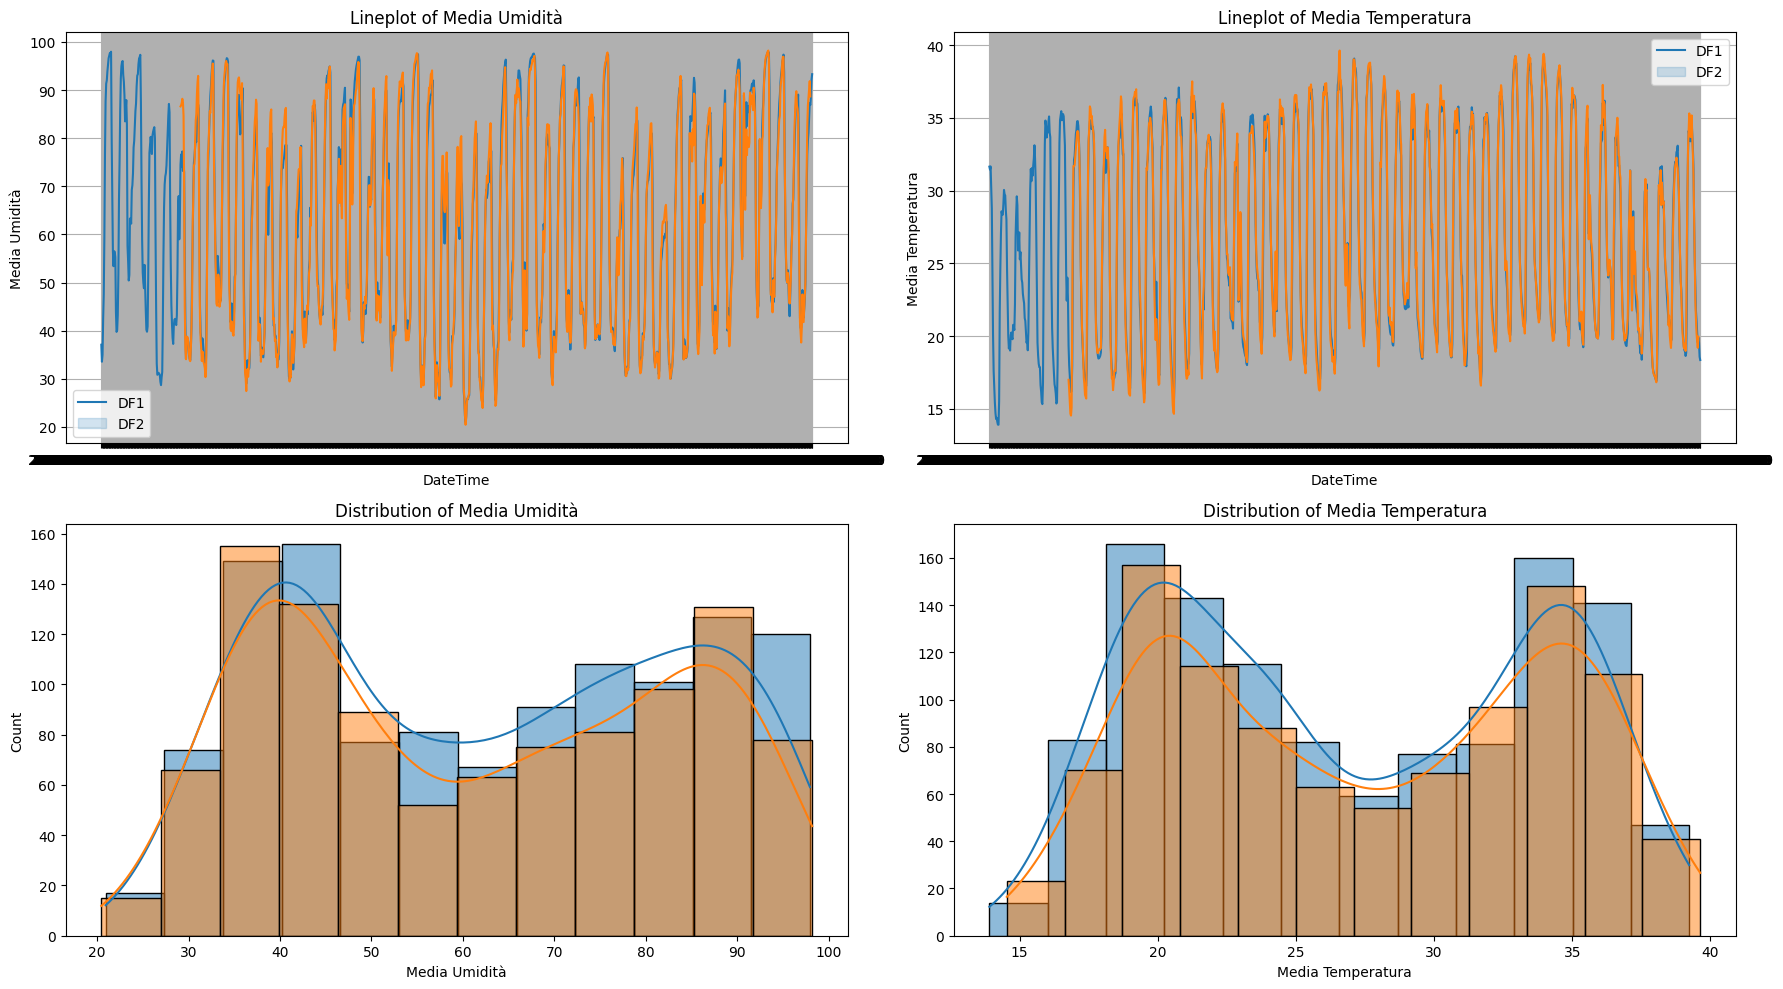

In [7]:
#@title Confronto Dataset 1 e 2

column_names = ['Media Temperatura', 'Media Umidità']
plot_line_and_distribution([df_1[column_names],df_2[column_names]], 'DateTime')


Gli andamenti temporali (grafici superiori) mostrano poche discrepanze nei livelli medi generali di umidità e temperatura.  
Gli istogrammi (grafici inferiori) mostrano distribuzioni delle medie di temperatura e umidità smili, con picchi e varianza paragonabili.  
Sulla base di queste considerazioni, **si è deciso di accorpare le informazioni dei due dataset**.

In [8]:
#@title Unione Dati Meteorologici:
df_1 = df_1.apply(pd.to_numeric, errors='coerce')
df_2 = df_2.apply(pd.to_numeric, errors='coerce')
# Trova gli indici comuni e non comuni
indici_comuni = df_1.index.intersection(df_2.index)
indici_non_comuni_df_1 = df_1.index.difference(df_2.index)
indici_non_comuni_df_2 = df_2.index.difference(df_1.index)

# Calcola la media per gli indici comuni
media_comuni = pd.DataFrame({
    col: (
        pd.to_numeric(df_1.loc[indici_comuni, col], errors='coerce') +
        pd.to_numeric(df_2.loc[indici_comuni, col], errors='coerce')
    ) / 2
    for col in df_1.columns
}, index=indici_comuni)

# Per gli indici non comuni, prendi i dati originali
righe_non_comuni_df_1 = df_1.loc[indici_non_comuni_df_1]
righe_non_comuni_df_2 = df_2.loc[indici_non_comuni_df_2]

# Combina i dati per gli indici comuni e non comuni
dataset_completo = pd.concat([
    media_comuni,
    righe_non_comuni_df_1,
    righe_non_comuni_df_2
])

# Assicuriamoci che l'indice sia in formato datetime
dataset_completo.index = pd.to_datetime(dataset_completo.index, format="%Y-%m-%d %H:%M:%S")

# Ordina il DataFrame per indice datetime
df_meteo_completo = dataset_completo.sort_index()

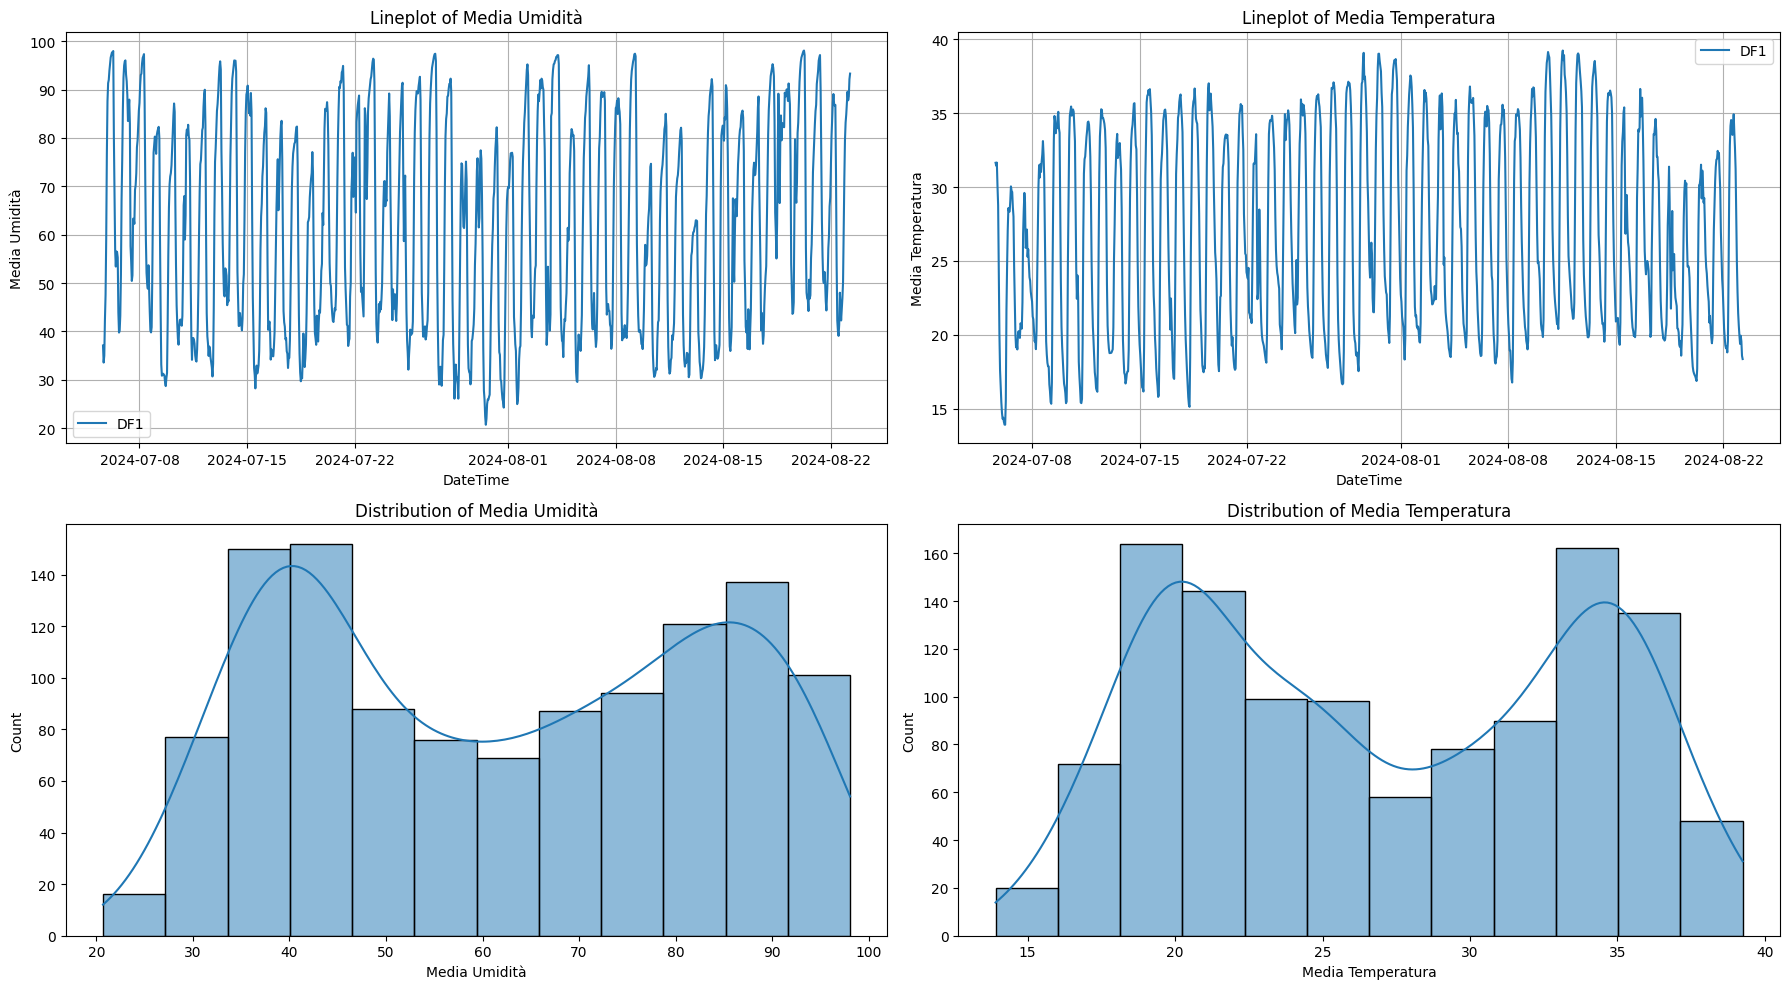

In [9]:
#@title Data Visualization -  Investigazione dei dati dopo l'unione (Media Umidità e Media Temperatura)

column_names = ['Media Temperatura', 'Media Umidità']
plot_line_and_distribution([df_meteo_completo[column_names]], 'DateTime')


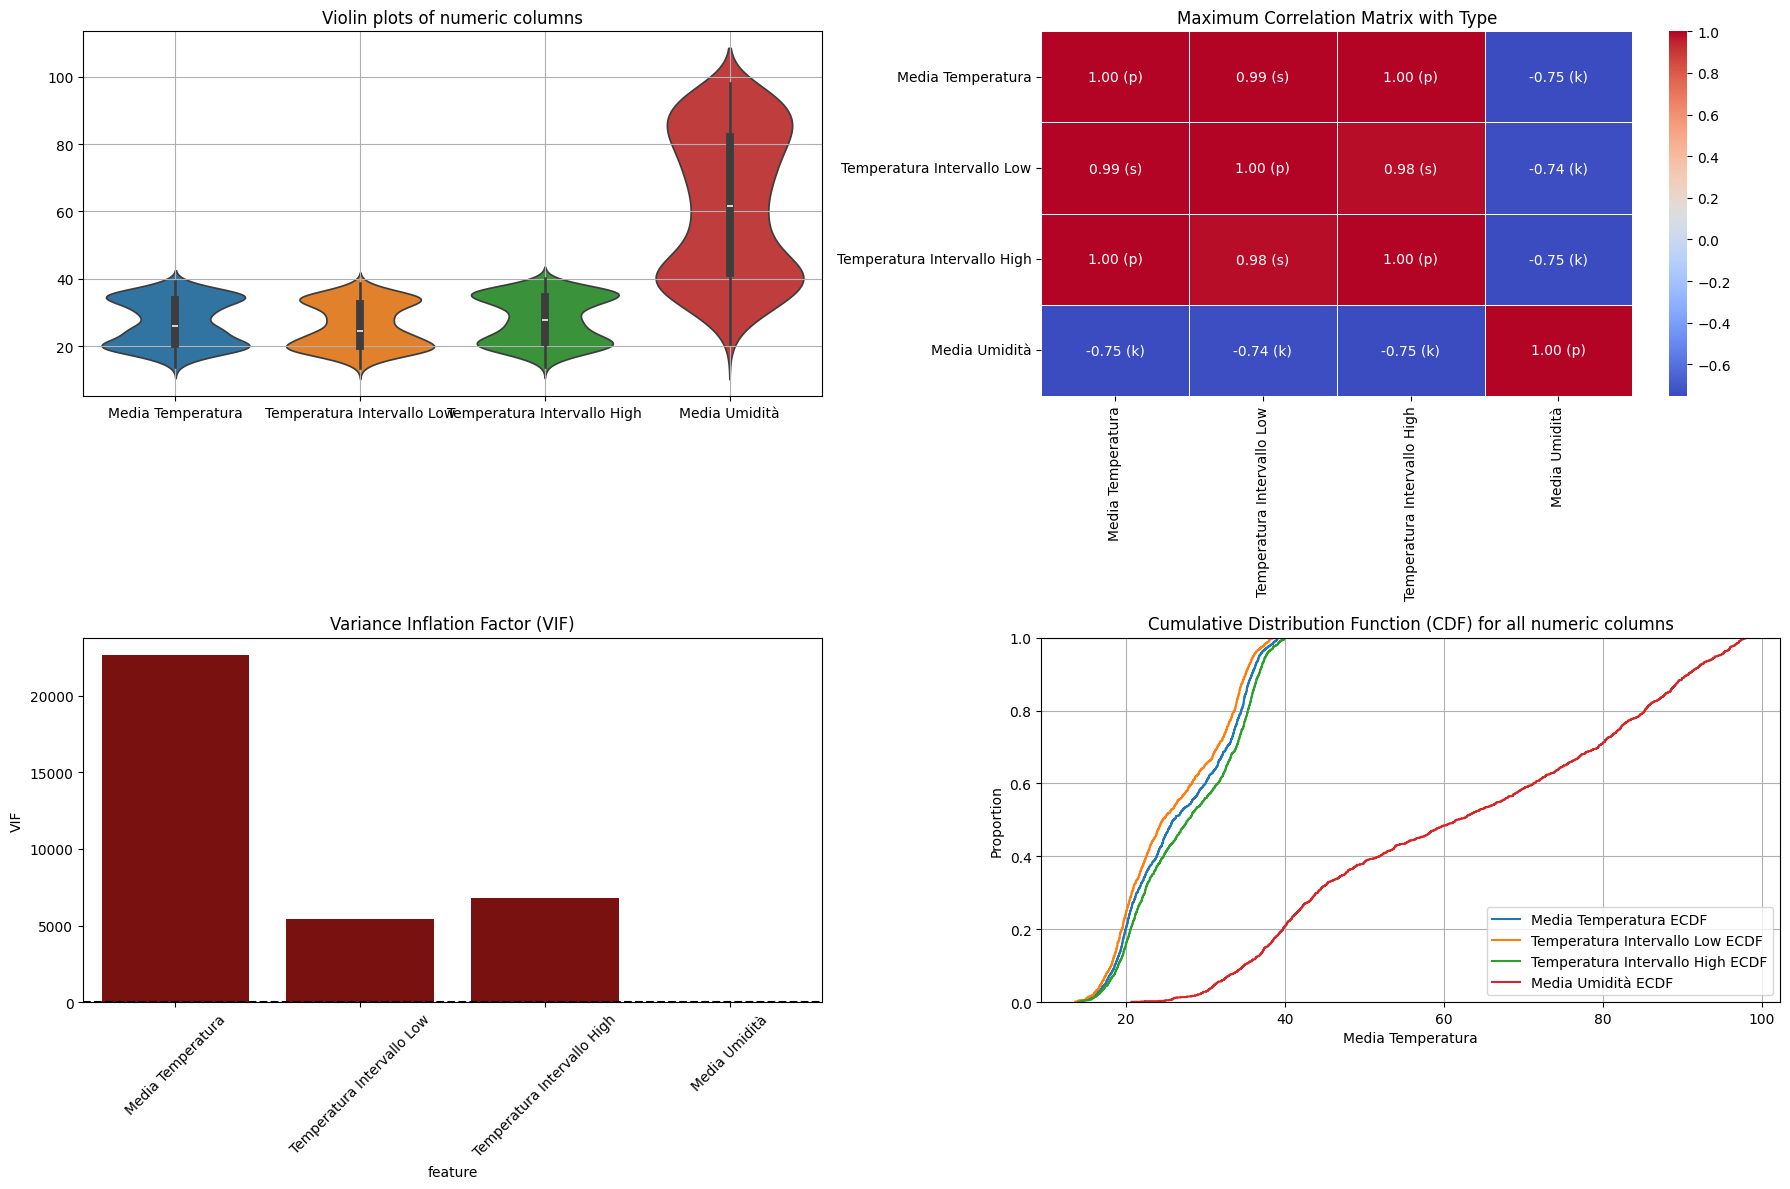

In [10]:
#@title Visualizzazione grafici dataset completo
create_grid_visualizations(df_meteo_completo)

                           Data       Ora
DateTime                                 
2024-07-05 15:00:00  2024-07-05  15:00:00
2024-07-05 16:00:00  2024-07-05  16:00:00
2024-07-05 17:00:00  2024-07-05  17:00:00
2024-07-05 18:00:00  2024-07-05  18:00:00
2024-07-05 19:00:00  2024-07-05  19:00:00


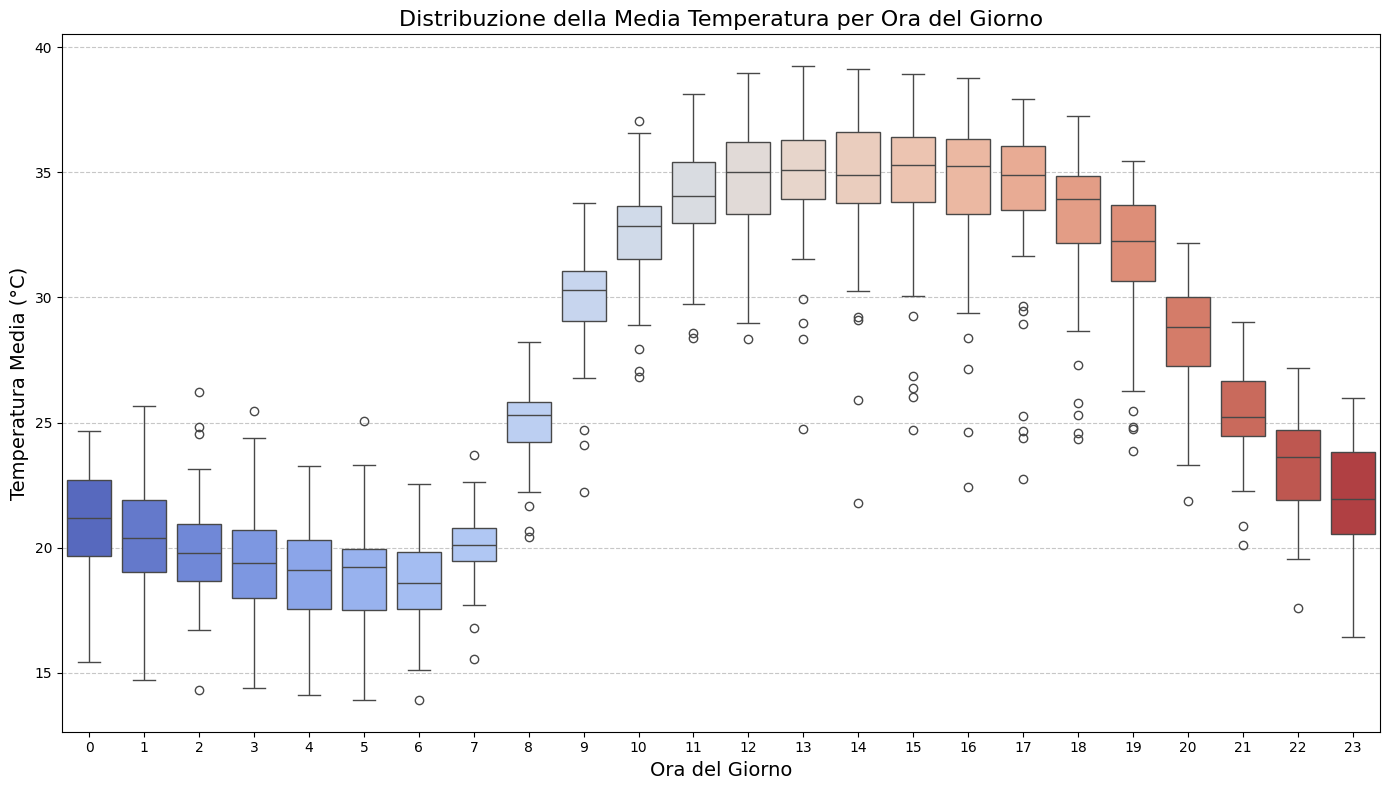

In [11]:
#@title Visualizzazione Temperatura Arco della giornata
# Assicurati che l'indice sia di tipo datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index)

# Splitta l'indice datetime in due nuove colonne
df_meteo_completo['Data'] = df_meteo_completo.index.date  # Solo la data
df_meteo_completo['Ora'] = df_meteo_completo.index.time  # Solo l'ora

# Visualizza il risultato
print(df_meteo_completo[['Data', 'Ora']].head())  # Mostra le prime righe delle nuove colonne

# Assicurati che l'indice sia datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index)

# Crea una colonna con l'ora (senza minuti e secondi)
df_meteo_completo['Ora'] = df_meteo_completo.index.hour

# Box plot della Media Temperatura per ogni ora
plt.figure(figsize=(14, 8))
sns.boxplot(x='Ora', y='Media Temperatura', data=df_meteo_completo, palette="coolwarm")
plt.title('Distribuzione della Media Temperatura per Ora del Giorno', fontsize=16)
plt.xlabel('Ora del Giorno', fontsize=14)
plt.ylabel('Temperatura Media (°C)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


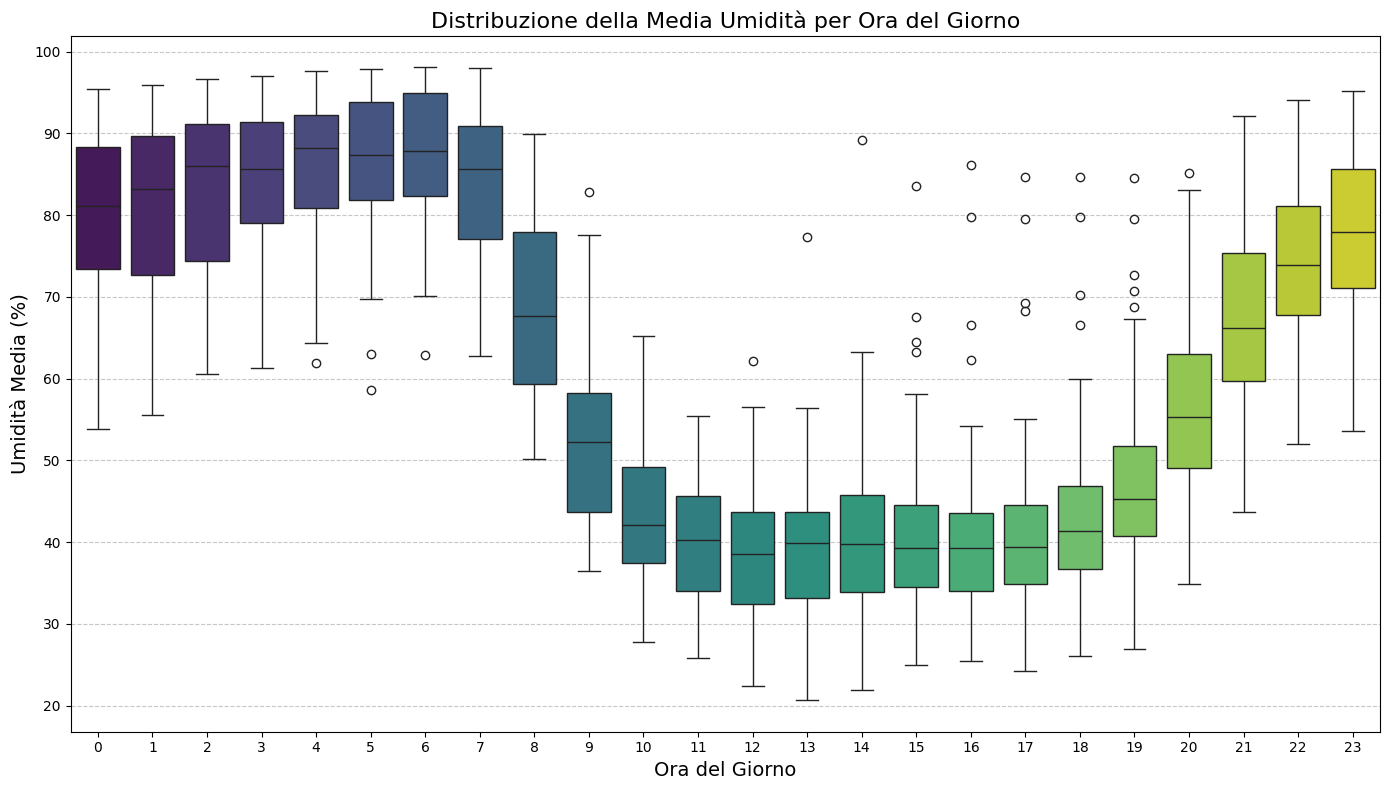

In [12]:
#@title Visualizzazione Umidità durante l'arco della giornata
# Assicurati che l'indice sia datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index)

# Crea una colonna con l'ora (senza minuti e secondi)
df_meteo_completo['Ora'] = df_meteo_completo.index.hour

# Box plot della Media Umidità per ogni ora
plt.figure(figsize=(14, 8))
sns.boxplot(x='Ora', y='Media Umidità', data=df_meteo_completo, palette="viridis")
plt.title('Distribuzione della Media Umidità per Ora del Giorno', fontsize=16)
plt.xlabel('Ora del Giorno', fontsize=14)
plt.ylabel('Umidità Media (%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Dal momento che i dati sulle catture sono forniti per giorni, scegliamo di accorpare i dati meteo relativi allo stesso giorno e conservare le informazioni relative a media e varianza di temperatura e umidità

In [13]:
#@title Eliminazione orario dall'indice
# Eliminiamo l'orario dall'indice per andare ad accorpare tutti i dati dello stesso giorno

# Assicuriamoci che l'indice sia in formato datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index, format="%Y-%m-%d %H:%M:%S")

# Mantieni solo la parte della data
df_meteo_completo.index = df_meteo_completo.index.date
print(df_meteo_completo.head())

            Media Temperatura  Temperatura Intervallo Low  \
2024-07-05              31.65                        31.1   
2024-07-05              31.45                        31.0   
2024-07-05              31.66                        31.2   
2024-07-05              30.08                        29.2   
2024-07-05              28.78                        26.5   

            Temperatura Intervallo High  Media Umidità        Data  Ora  
2024-07-05                         32.2          37.08  2024-07-05   15  
2024-07-05                         32.2          33.55  2024-07-05   16  
2024-07-05                         32.1          34.98  2024-07-05   17  
2024-07-05                         30.8          42.39  2024-07-05   18  
2024-07-05                         29.6          47.54  2024-07-05   19  


In [14]:
#@title Accorpamento dati stesso giorno


# Assicuriamoci che l'indice sia in formato datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index, format="%Y-%m-%d %H:%M:%S")

# Funzioni di aggregazione per le colonne specifiche
agg_functions = {
    'Media Temperatura': ['mean', 'var'],  # Media e varianza
    'Media Umidità': ['mean', 'var'],      # Media e varianza
    'Temperatura Intervallo High': 'max',  # Valore massimo
    'Temperatura Intervallo Low': 'min'    # Valore minimo
}

# Raggruppa per indice (data) e calcola le statistiche
df_aggregato = df_meteo_completo.groupby(df_meteo_completo.index).agg(agg_functions)

# Flatten the MultiIndex columns (because we have multiple aggregations per column)
df_aggregato.columns = [' '.join(col).strip() for col in df_aggregato.columns.values]




In [15]:
#@title Rinomina colonne
df_aggregato.rename(columns={'Media Temperatura mean': 'Media Temperatura'}, inplace=True)
df_aggregato.rename(columns={'Media Temperatura var': 'Varianza Temperatura'}, inplace=True)
df_aggregato.rename(columns={'Media Umidità mean': 'Media Umidità'}, inplace=True)
df_aggregato.rename(columns={'Media Umidità var': 'Varianza Umidità'}, inplace=True)
df_aggregato.rename(columns={'Temperatura Intervallo High max': 'Temperatura Massima'}, inplace=True)
df_aggregato.rename(columns={'Temperatura Intervallo Low min': 'Temperatura Minima'}, inplace=True)


#Analisi preliminare Dati Cattura

I file rappresentano un registro delle catture di insetti in un intervallo temporale.	Contengono annotazioni sugli eventi che possono aver influenzato i dati, come il reset delle trappole.

In [16]:
print("Dati Cicalino 1: ")
print(df_ca_1.describe())
print("---------------------------------------------\n")
print("Dati Cicalino 2: ")
print(df_ca_1.describe())

Dati Cicalino 1: 
       Numero di insetti  Nuove catture (per evento)
count          49.000000                   49.000000
mean            0.428571                    0.183673
std             0.677003                    0.441280
min             0.000000                    0.000000
25%             0.000000                    0.000000
50%             0.000000                    0.000000
75%             1.000000                    0.000000
max             3.000000                    2.000000
---------------------------------------------

Dati Cicalino 2: 
       Numero di insetti  Nuove catture (per evento)
count          49.000000                   49.000000
mean            0.428571                    0.183673
std             0.677003                    0.441280
min             0.000000                    0.000000
25%             0.000000                    0.000000
50%             0.000000                    0.000000
75%             1.000000                    0.000000
max             

L'orario non costituisce un'informazione rilevante in quanto i dati sulle catture sono forniti con cadenza giornaliera, sempre alla stessa ora, con leggere discrepanze nei minuti

In [17]:
#@title Eliminazione orario dall'indice

# Assicurati che l'indice sia in formato datetime
df_ca_1.index = pd.to_datetime(df_ca_1.index, format="%Y-%m-%d %H:%M:%S")
# Mantieni solo la parte della data
df_ca_1.index = df_ca_1.index.date

# Assicurati che l'indice sia in formato datetime
df_ca_2.index = pd.to_datetime(df_ca_2.index, format="%Y-%m-%d %H:%M:%S")
# Mantieni solo la parte della data
df_ca_2.index = df_ca_2.index.date

# Aggiungiamo lo 0 ai valori Nan -> questo lo facciamo poiché le righe di Cleaning
# Sono separate a quelle delle catture, ma avvengono lo stesso giorno, in questo modo
# possiamo andarle ad accorpare semplicemente facendo una somma
df_ca_1 = df_ca_1.fillna(0)
df_ca_2 = df_ca_2.fillna(0)

In [18]:
#@title Conversione colonne evento in binario
df_ca_1['Evento'] = (df_ca_1['Evento'] == 'Cleaning').astype(int)
df_ca_2['Evento'] = (df_ca_2['Evento'] == 'Cleaning').astype(int)

La colonna "Recensito" non è informativa (varianza nulla), quindi la eliminiamo dal dataset

In [19]:
#@title Eliminazione Colonna Recensito
df_ca_1 = df_ca_1.drop(['Recensito'], axis=1)
df_ca_2 = df_ca_2.drop(['Recensito'], axis=1)

In [20]:
#@title Somma Righe con stessa data
df_ca_1 = df_ca_1.groupby(df_ca_1.index).sum()
df_ca_2 = df_ca_2.groupby(df_ca_2.index).sum()


In [21]:
#@title Unione grafico catture 1 e 2
# Merge df_ca_1 and df_ca_2
merged_df = pd.merge(df_ca_1, df_ca_2, left_index=True, right_index=True, how='inner', suffixes=('_1', '_2'))

# Fill NaN values with 0 in 'Numero di insetti' and 'Nuove catture (per evento)' columns
merged_df['Numero di insetti_1'].fillna(0, inplace=True)
merged_df['Numero di insetti_2'].fillna(0, inplace=True)
merged_df['Nuove catture (per evento)_1'].fillna(0, inplace=True)
merged_df['Nuove catture (per evento)_2'].fillna(0, inplace=True)

# Sum the 'Numero di insetti' and 'Nuove catture (per evento)' columns
merged_df['Numero di insetti'] = merged_df['Numero di insetti_1'] + merged_df['Numero di insetti_2']
merged_df['Nuove catture (per evento)'] = merged_df['Nuove catture (per evento)_1'] + merged_df['Nuove catture (per evento)_2']

# Drop delle colonne non necessarie
df_catture_cicalino = merged_df.drop(['Numero di insetti_1', 'Numero di insetti_2',
                           'Nuove catture (per evento)_1', 'Nuove catture (per evento)_2'], axis=1)


In [22]:
#@title Estrazione Variabili Target

Target_numero_insetti = df_catture_cicalino.copy()
Target_numero_insetti = Target_numero_insetti.drop(['Nuove catture (per evento)'], axis=1)

# Si poteva pensare di gestire le Feature Evento_1 e Evento_2 come un'unica feature
# Target_numero_insetti['Evento'] = Target_numero_insetti['Evento_1'] + Target_numero_insetti['Evento_2']
# Target_numero_insetti = Target_numero_insetti.drop(['Evento_1', 'Evento_2'], axis=1)

Target_nuove_catture = df_catture_cicalino.copy()
Target_nuove_catture = Target_nuove_catture.drop(['Evento_1', 'Evento_2','Numero di insetti'], axis=1)
Target_nuove_catture['Nuove catture (per evento)'] = (Target_nuove_catture['Nuove catture (per evento)'] >= 1).astype(int)


#Costruzione dataset finale

In [23]:
#@title Unione Variabile Target con Dati Meteo
# La variabile How indica come vengono unite le colonne, in questo caso si è scelto "inner"
# In questo modo prendiamo solo i valori con indici comuni con il fine di non avere
# valori Nan specialmente sulla variabile target
df_finale_regressione = df_aggregato.join(Target_numero_insetti, how='inner')
df_finale_classificazione = df_aggregato.join(Target_nuove_catture, how='inner')

In [24]:
#@title Salvataggio Dataset
df_finale_regressione.to_csv('df_finale_regressione_cicalino.csv')
df_finale_classificazione.to_csv('df_finale_classificazione_cicalino.csv')

In [25]:
#@title Conteggio valori nulli
print(df_finale_regressione.isnull().sum())

Media Temperatura       0
Varianza Temperatura    0
Media Umidità           0
Varianza Umidità        0
Temperatura Massima     0
Temperatura Minima      0
Evento_1                0
Evento_2                0
Numero di insetti       0
dtype: int64


# Problema Regressione

Si effettua in prima istanza un'analisi visiva tramite scatter plot. Questa visualizzazione permette di valutare visivamente l’impatto di determinate variabili sul numero di catture.

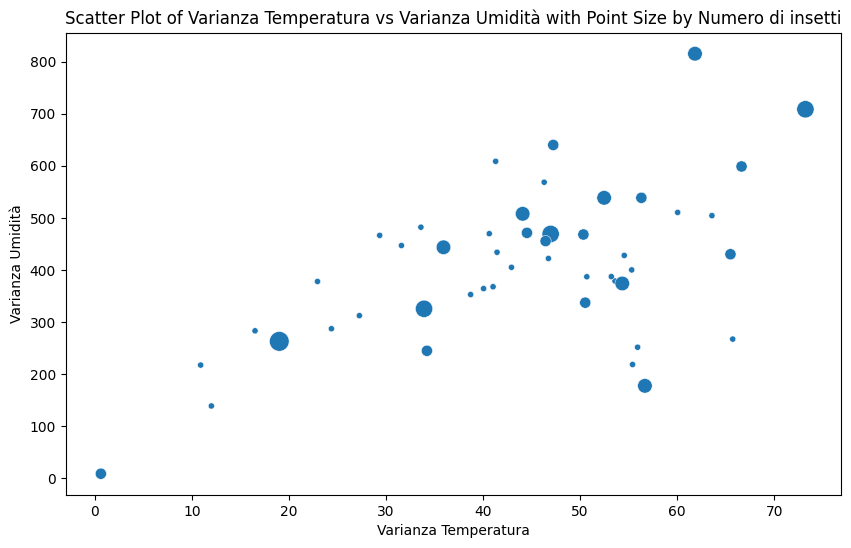

In [26]:
#@title Visualizzazione dei Dati: Esplorare le relazioni tra le variabili
def plot_scatter_with_size(df, x_col, y_col, size_col, figsize=(10, 6)):
    """
    Creates a scatter plot using two columns from a dataframe,
    with the size of the points determined by a third column.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot.
    x_col (str): Name of the column for the x-axis.
    y_col (str): Name of the column for the y-axis.
    size_col (str): Name of the column to determine the size of the points.
    figsize (tuple): Size of the figure (width, height).
    """

    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x_col, y=y_col, size=size_col, legend=False, sizes=(20, 200))

    plt.title(f'Scatter Plot of {x_col} vs {y_col} with Point Size by {size_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.show()


plot_scatter_with_size(df_finale_regressione ,	"Varianza Temperatura", "Varianza Umidità", 'Numero di insetti')

Si passa quindi ad un'analisi visivo-quantitativa che combina tecniche statistiche e visualizzazioni per comprendere i pattern, le relazioni e le caratteristiche dei dati.

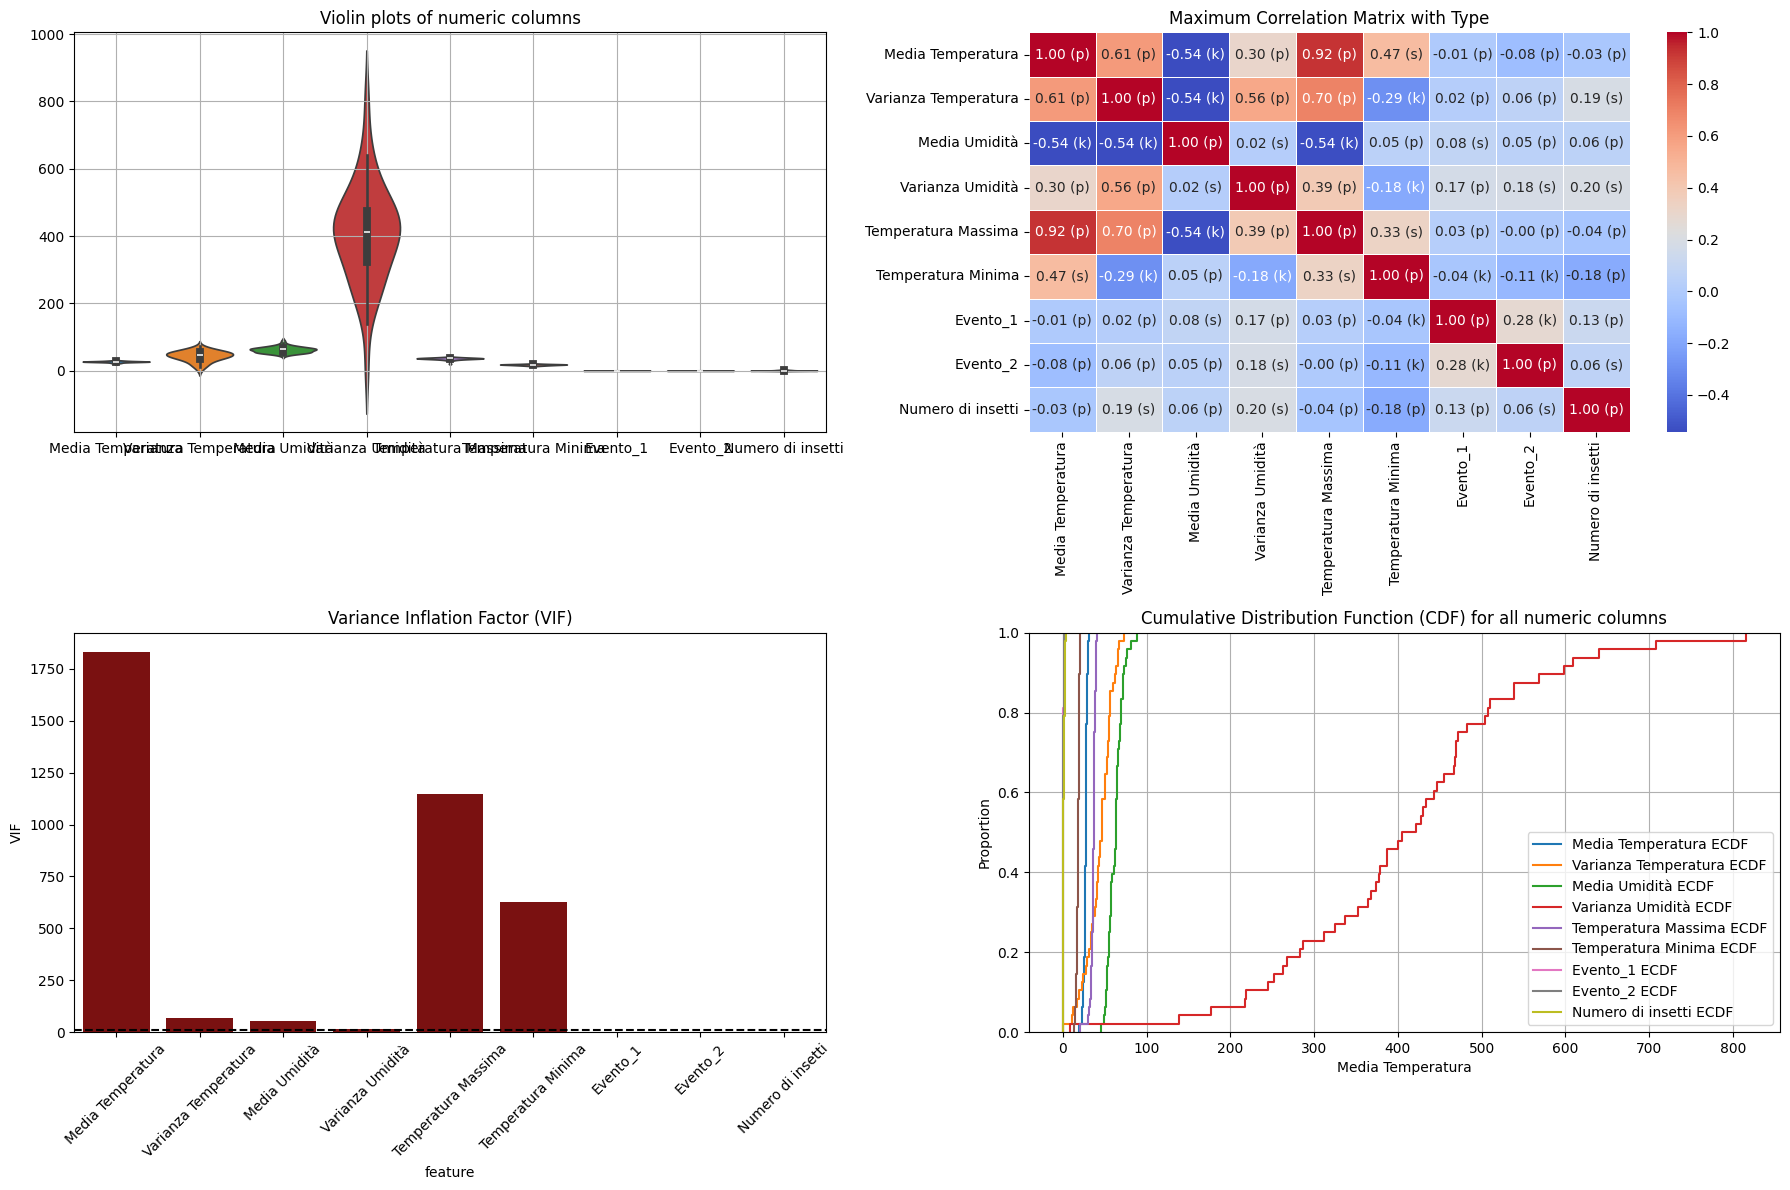

In [27]:
#@title Analisi Esplorativa dei Dati: Analisi Visivo-Quantitativa

create_grid_visualizations(df_finale_regressione)


Sulle base delle analisi effettuate, si è deciso di eliminare le feature "Media Temperatura", "Evento 2" e "Media Umidità" ed utilizzare la tecnica della PCA per "Varianza temperature e Varianza umidità", che risultano correlate

In [28]:
#@title Eliminazione Features e PCA
df_features_drop = df_finale_regressione.copy()

# Andiamo a misurare varianza la temperatura dei 3 giorni precedenti

df_features_drop['Varianza Temperatura (giorni precedenti)'] = df_features_drop['Varianza Temperatura'].rolling(window=3).sum()
# gestione valori nulli -> media
# Le prime istanze saranno in realtà già eliminate dopo quando si andranno ad aggiungere le colonne lag
df_features_drop['Varianza Temperatura (giorni precedenti)'] = df_features_drop['Varianza Temperatura (giorni precedenti)'].fillna(df_features_drop['Varianza Temperatura (giorni precedenti)'].mean())

#Eliminazione Media Temperatura Evento_2 e Media Umidità e Media Temperatura
df_features_drop = df_features_drop.drop(['Media Temperatura', 'Media Umidità','Evento_2'], axis=1)

#PCA Temperatura Massima e Minima
scaler = StandardScaler()
features_scaled_temperatura = scaler.fit_transform(df_features_drop[['Temperatura Massima', 'Temperatura Minima']])
pca = PCA(n_components=1)
df_features_drop['Temperatura_pca'] = pca.fit_transform(features_scaled_temperatura)
df_features_drop = df_features_drop.drop(['Temperatura Massima', 'Temperatura Minima'], axis=1)

feature_scaled_varianza = scaler.fit_transform(df_features_drop[['Varianza Temperatura', 'Varianza Umidità']])
# PCA Creazione di un'unica varianza
df_features_drop['varianza_pca'] = pca.fit_transform(feature_scaled_varianza)
df_features_drop = df_features_drop.drop(['Varianza Temperatura', 'Varianza Umidità'], axis=1)



In [29]:
df_features_drop.to_csv('df_finale_regressione_cicalino_post_features_selection.csv')

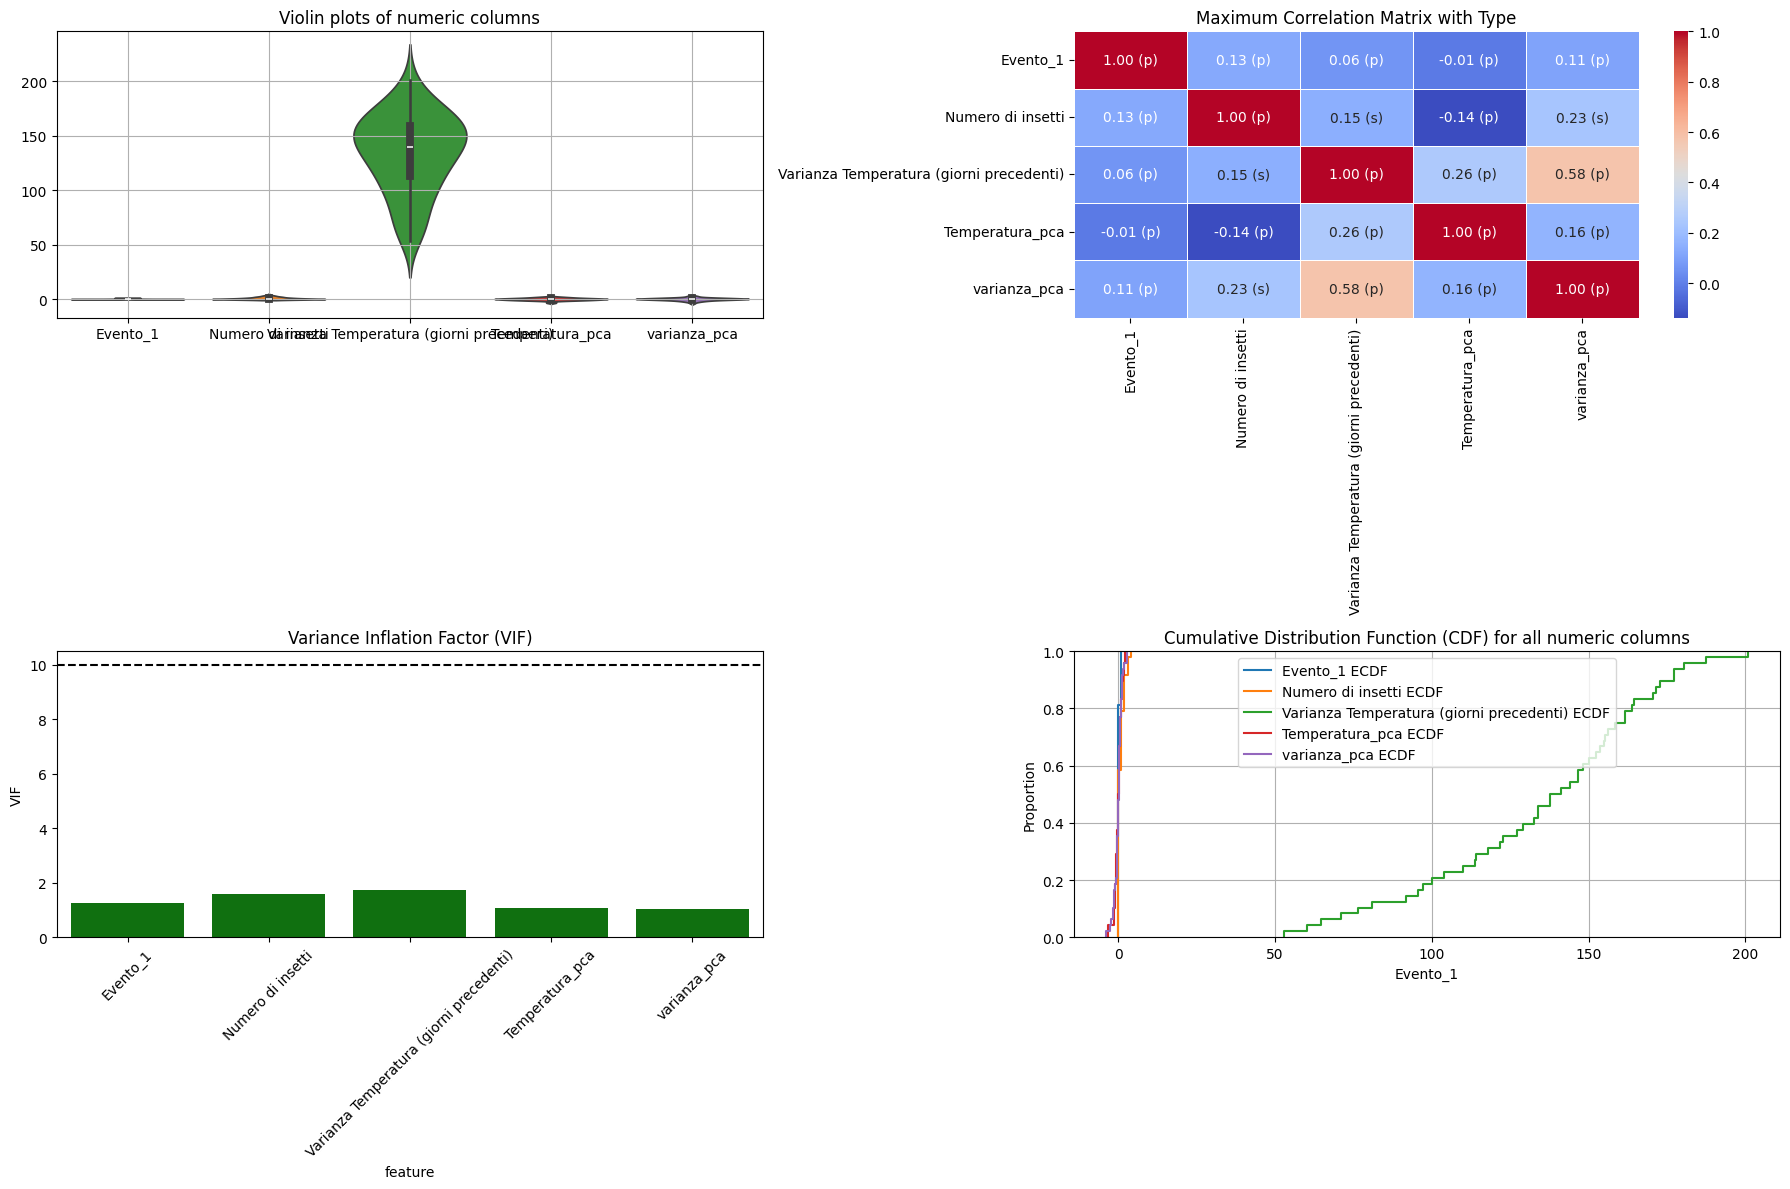

In [30]:
create_grid_visualizations(df_features_drop)

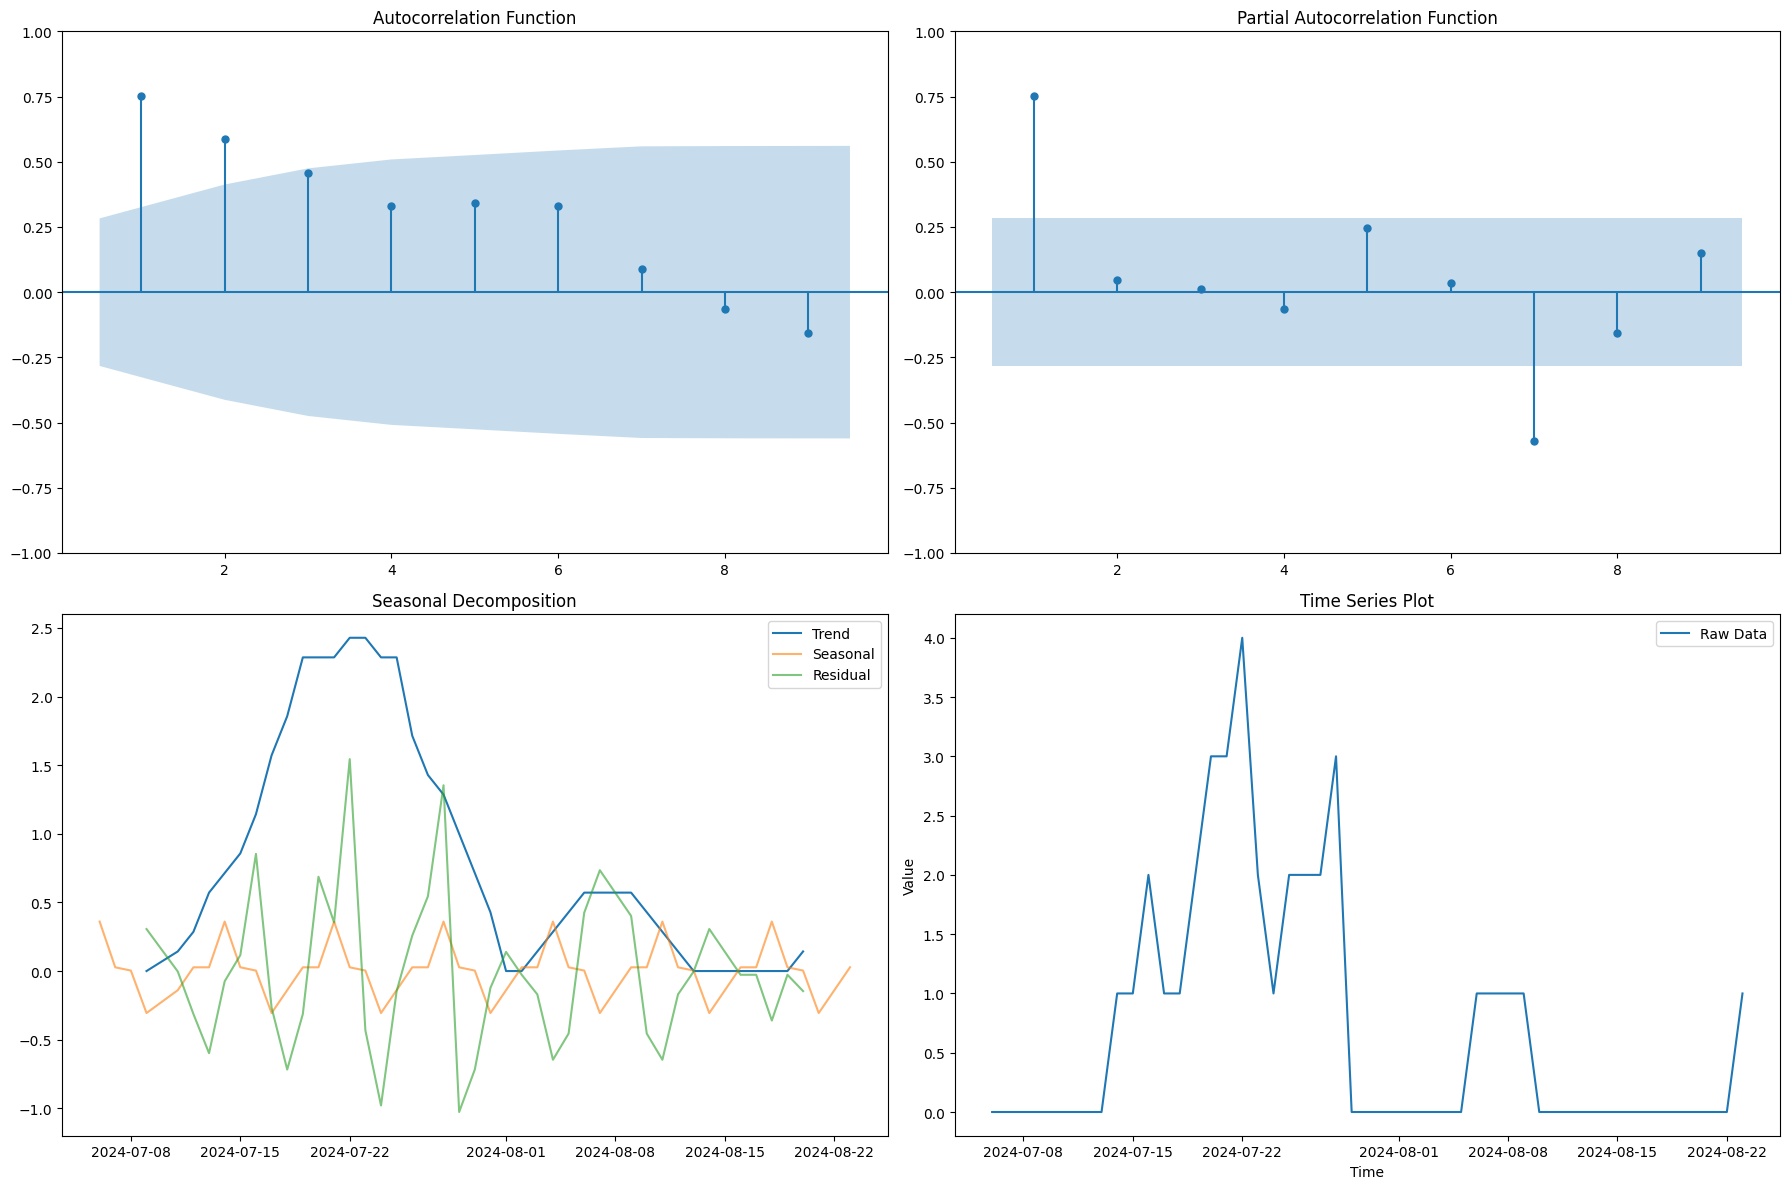

In [31]:
#@title Analisi Esplorativa dei Dati: Serie Temporali

advanced_time_series_analysis(df_finale_regressione, 'Numero di insetti', lags=9, period=7)  # Adjust 'period' as necessary based on your dataset



## Addestramento

Per l'addestramento si è deciso di utilizzare e confrontare:
- un **modello statistico** (ARIMAX);
- una **tecnica di Machine Learning** (Ensamble Learning);
- una **tecnica di Deep Learning** (MLP+Cross Validation).

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

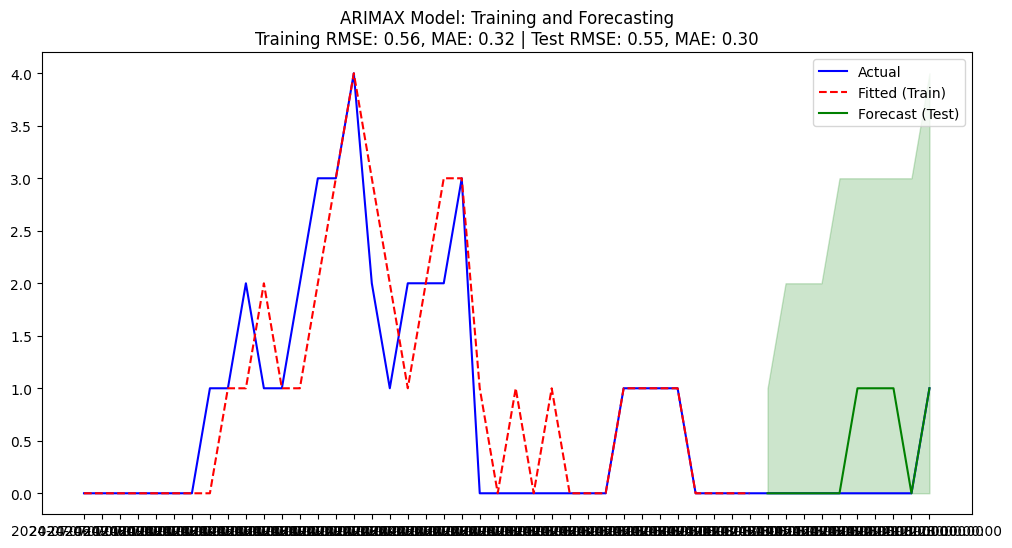

In [32]:
#@title ARIMAX Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume data_clean is your DataFrame with the required columns
data_clean = df_finale_regressione.copy()
data_clean = df_features_drop.copy()

# Controllo sulla data
data_clean.index = pd.to_datetime(data_clean.index, format="%Y-%m-%d %H:%M:%S")
data_clean.index = data_clean.index.strftime('%Y-%m-%d %H:%M:%S')

#data_clean = df.copy()
y = data_clean['Numero di insetti']
columns = data_clean.columns.tolist()
columns.remove('Numero di insetti')
X = data_clean[columns]

# Chronological Split of Data into Training and Testing Sets
train_size = int(len(data_clean) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

# Define and Fit the ARIMAX model on the Training Data
arimax_model = sm.tsa.ARIMA(endog=y_train, exog=X_train, order=(4, 1, 5)).fit()

# Predictions on the Training Data
fitted_values_train = arimax_model.fittedvalues.clip(lower=0).round()

# Forecasting on the Test Data
arimax_forecast = arimax_model.get_forecast(steps=len(y_test), exog=X_test)
forecasted_values_test = arimax_forecast.predicted_mean.clip(lower=0).round()
confidence_intervals_test = arimax_forecast.conf_int()
confidence_intervals_test[confidence_intervals_test < 0] = 0  # Ensure non-negative bounds
confidence_intervals_test = confidence_intervals_test.round()

# Calculate Residuals
residuals_train_arimax = y_train - fitted_values_train
residuals_test_arimax = y_test - forecasted_values_test

# Calculate Metrics
# Training Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, fitted_values_train))
mae_train = mean_absolute_error(y_train, fitted_values_train)

# Test Metrics
rmse_test = np.sqrt(mean_squared_error(y_test, forecasted_values_test))
mae_test = mean_absolute_error(y_test, forecasted_values_test)

# Plotting the Results
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting Actual, Fitted, and Forecasted Values
ax.plot(y.index, y, label='Actual', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Fitted (Train)')
ax.plot(forecasted_values_test.index, forecasted_values_test, label='Forecast (Test)', color='green')
ax.fill_between(confidence_intervals_test.index, confidence_intervals_test.iloc[:, 0], confidence_intervals_test.iloc[:, 1], color='green', alpha=0.2)
#recent_date = y.index[-1]  # Ultima data
#start_date = recent_date - pd.Timedelta(days=50)  # 90 giorni fa

#ax.set_xlim(start_date, recent_date)
# Title and Legend
ax.set_title(f'ARIMAX Model: Training and Forecasting\nTraining RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f} | Test RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
ax.legend()

plt.show()


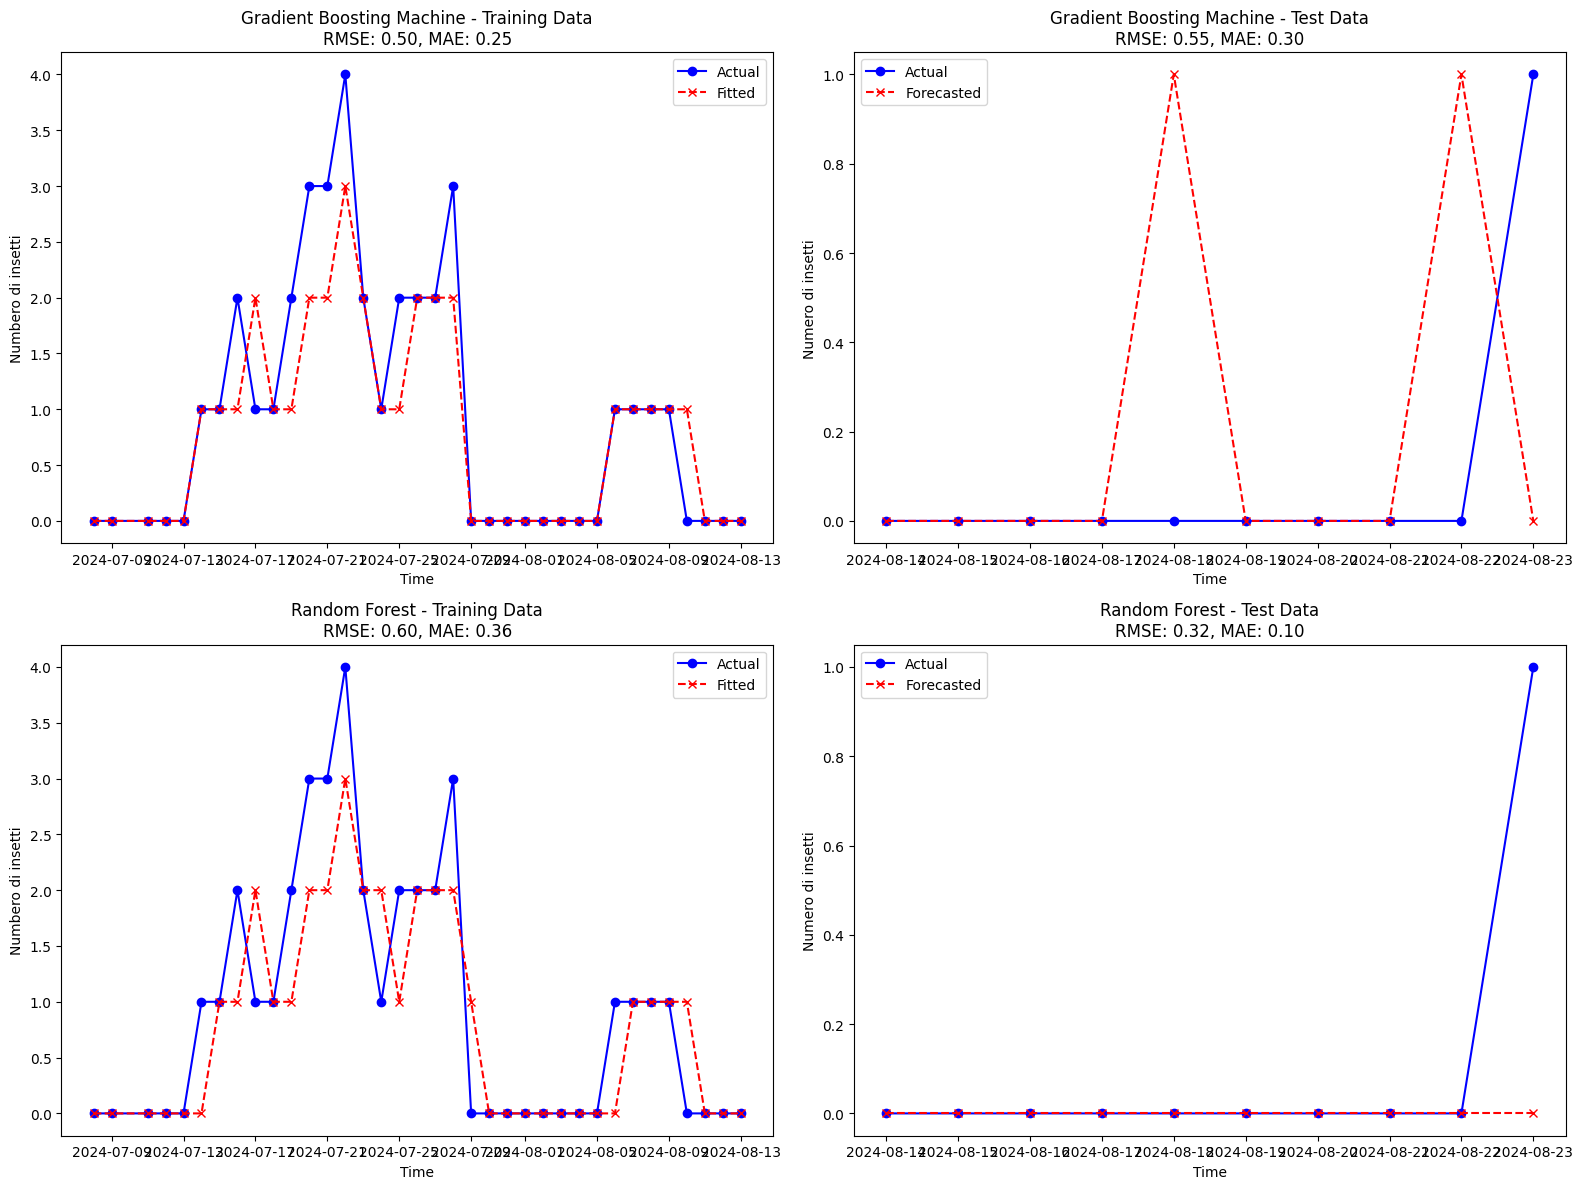

In [33]:
#@title Gradient Boosting e Random Forest
#@title Addestramento per valutazione Features
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

def create_lagged_features(df, n_lags=5, target_col='Numero di insetti', exog_cols=[]):
    """ Create lagged features for the target and use exogenous columns as is. """
    # Create lagged features for the target column only
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

def train_and_visualize(df, n_lags, exog_cols,target_col):
    """ Train models and visualize the results, using exogenous columns without lags. """
    df = create_lagged_features(df, n_lags=n_lags, exog_cols=exog_cols)

    # Use only lagged features of the target and direct use of exogenous columns
    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = df[feature_cols]
    y = df[target_col]

    # Chronological Split of Data
    train_size = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Gradient Boosting Machine": GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=3),
        "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=2)
    }

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Clipping and rounding the predictions
        y_pred_train = np.clip(y_pred_train, 0, None).round()
        y_pred_test = np.clip(y_pred_test, 0, None).round()

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # Actual vs. Fitted on Training Data
        axs[i][0].plot(y_train.index, y_train, label='Actual', marker='o', color='blue')
        axs[i][0].plot(y_train.index, y_pred_train, label='Fitted', linestyle='--', marker='x', color='red')
        axs[i][0].set_title(f'{name} - Training Data\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}')
        axs[i][0].set_xlabel('Time')
        axs[i][0].set_ylabel('Numbero di insetti')
        axs[i][0].legend()

        # Forecast vs. Actual on Test Data
        axs[i][1].plot(y_test.index, y_test, label='Actual', marker='o', color='blue')
        axs[i][1].plot(y_test.index, y_pred_test, label='Forecasted', linestyle='--', marker='x', color='red')
        axs[i][1].set_title(f'{name} - Test Data\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
        axs[i][1].set_xlabel('Time')
        axs[i][1].set_ylabel('Numero di insetti')
        axs[i][1].legend()

    plt.tight_layout()
    plt.show()
    return models , df

# Assuming df_2 is your DataFrame and it contains the necessary data
df_copia = df_finale_regressione.copy()
df_copia = df.copy()
df_copia = df_features_drop.copy()
Columns = df_copia.columns.tolist()
if 'Numero di insetti' in Columns:
  Columns.remove('Numero di insetti')
Variabili_esogene = Columns

rf_models, real_data = train_and_visualize(df_copia, n_lags=2, exog_cols=Variabili_esogene, target_col='Numero di insetti')

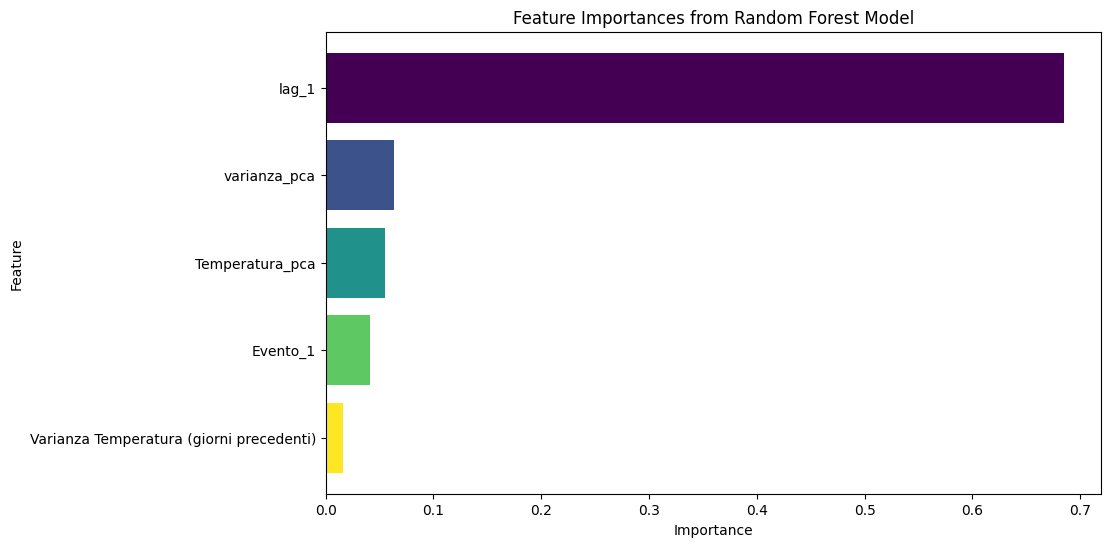

In [34]:
# Seleziona il modello di Random Forest dal dizionario
rf_model = rf_models['Random Forest']

# Ora puoi accedere alle feature importances
importances = rf_model.feature_importances_

# Feature names (quelli che hai usato per addestrare il modello)
feature_names = [f'lag_{i}' for i in range(1, 2)] + Variabili_esogene  # Assicurati che queste corrispondano ai nomi reali

# Crea la lista di tuple (importanza, nome della feature) e ordina
feature_importances = sorted(zip(importances, feature_names), reverse=True, key=lambda x: x[0])

# Unzip into separate lists
sorted_importances, sorted_features = zip(*feature_importances)

# Plotting the Feature Importances
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))
plt.barh(sorted_features, sorted_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,681 (14.38 KB)

 Trainable params: 3,553 (13.88 KB)

 Non-trainable params: 128 (512.00 B)


Epoch 1: val_loss improved from inf to 0.84285, saving model to best_model_mlp.keras

Epoch 2: val_loss did not improve from 0.84285

Epoch 3: val_loss did not improve from 0.84285

Epoch 4: val_loss did not improve from 0.84285

Epoch 5: val_loss did not improve from 0.84285

Epoch 6: val_loss improved from 0.84285 to 0.84228, saving model to best_model_mlp.keras

Epoch 7: val_loss improved from 0.84228 to 0.83460, saving model to best_model_mlp.keras

Epoch 8: val_loss improved from 0.83460 to 0.83197, saving model to best_model_mlp.keras

Epoch 9: val_loss improved from 0.83197 to 0.83154, saving model to best_model_mlp.keras

Epoch 10: val_loss improved from 0.83154 to 0.82137, saving model to best_model_mlp.keras

Epoch 11: val_loss improved from 0.82137 to 0.80902, saving model to best_model_mlp.keras

Epoch 12: val_loss improved from 0.80902 to 0.80677, saving model to best_model_mlp.keras

Epoch 13: val_loss improved from 0.80677 to 0.80410, saving model to best_model_mlp.kera

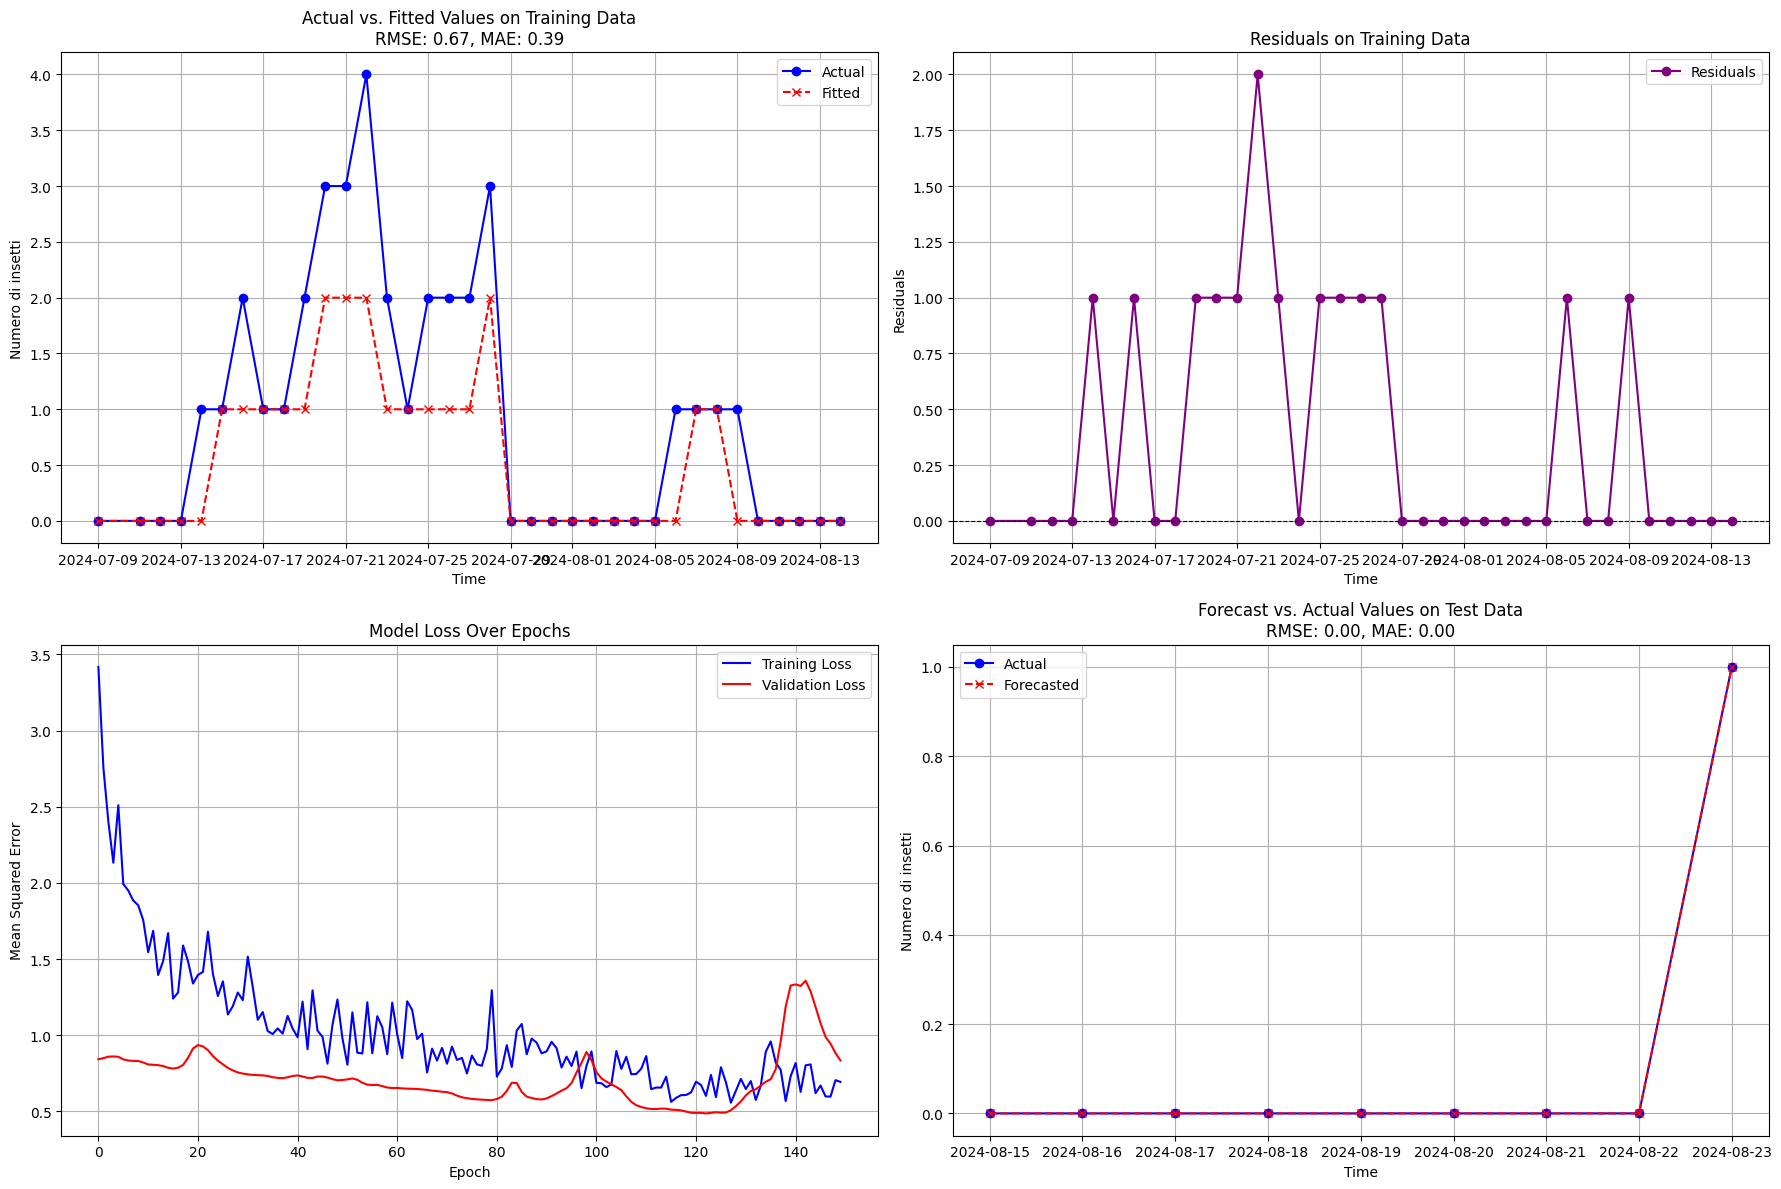

In [35]:
#@title DeepLearning MLP

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

def weighted_mse_loss(y_true, y_pred):
    # Calcola l'errore quadratico medio
    mse_loss = tf.square(y_true - y_pred)

    # Ponderazione: peso 1 per i valori predetti pari a 0, peso 2 per qualsiasi altro valore
    weights = tf.where(y_pred == 0, 1.0, 2.0)  # Se y_pred è 0, peso 1, altrimenti peso 2

    # Applica i pesi alla loss
    weighted_loss = weights * mse_loss

    return tf.reduce_mean(weighted_loss)

# Preprocessing and Creating Lagged Features
def create_lagged_features(df, n_lags=2, target_col='Numero di insetti', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 3  # Number of lags
df_copia = df_features_drop.copy()

columns = df_copia.columns.tolist()
if 'Numero di insetti' in columns:
  columns.remove('Numero di insetti')
exog_cols = columns
# Create lagged features including exogenous variables
lagged_df = create_lagged_features(df_copia, n_lags=n_lags, target_col='Numero di insetti', exog_cols=exog_cols)

# Define features and target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Numero di insetti']

# Splitting Data into training and test sets ->
# non può avvenire con lo shuffle, poiché si perdono le relazioni interne dei dati a livello temporale

train_size = int(len(lagged_df) * 0.8)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
# Define the model using TensorFlow Functional API
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(7, activation='relu')(inputs)
x = tf.keras.layers.Dense(15, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)


model_mlp = tf.keras.Model(inputs=inputs, outputs=outputs)

model_mlp.compile(optimizer='Adam', loss=weighted_mse_loss)
'''

# Define a complex MLP Model
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization layer for normalizing activations
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),  # Another Dropout layer
    tf.keras.layers.Dense(1, activation='linear')
])

# Setup a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Start with a higher learning rate
    decay_steps=1000,
    decay_rate=0.96,  # Smaller decay rate for a more gradual decrease
    staircase=True)

# Compile the model using Adam optimizer with a learning rate schedule
model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error')

'''
# Train the Model and include validation data to plot training and validation loss
history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=25,
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    verbose=2
)
'''
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='best_model_mlp.keras',  # File where the model is saved
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model
    mode='min',               # Minimize the loss
    verbose=1                 # Print info when the model is saved
)

# Model summary to display architecture
model_mlp.summary()
# Train the Model
history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=150,  # Increased epochs for more complex model
    batch_size=32,  # Adjusted batch size
    validation_data=(X_test_scaled, y_test),
    callbacks=[checkpoint],    # Add the ModelCheckpoint callback
    verbose=0
)

best_model_mlp = load_model('best_model_mlp.keras', custom_objects={'mean_squared_error': 'mean_squared_error'})

# Predictions on training and test data
y_train_pred = best_model_mlp.predict(X_train_scaled)
y_test_pred = best_model_mlp.predict(X_test_scaled)

# Post-processing to ensure non-negativity and rounding
y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

# Calculate RMSE and MAE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
mae_train = mean_absolute_error(y_train, y_train_pred_processed)

# Calculate RMSE and MAE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
mae_test = mean_absolute_error(y_test, y_test_pred_processed)

# Residuals on training data
residuals_train = y_train - y_train_pred_processed

# Prepare indices for plotting
y_train_index = y_train.index
y_test_index = y_test.index

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Actual vs. Fitted Values on Training Data
axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Numero di insetti')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residuals on Training Data
axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Training & Validation Loss Over Epochs
axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Forecast vs. Actual Values on Test Data
axs[1, 1].plot(y_test_index, y_test.values, label='Actual', marker='o', color='blue')
axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Numero di insetti')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [36]:
#model = model_mlp.save('trained_mlp.h5')


Fold 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 1 - Train RMSE: 0.60, MAE: 0.31
Fold 1 - Val RMSE: 0.47, MAE: 0.22
Fold 2


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 2 - Train RMSE: 0.33, MAE: 0.11
Fold 2 - Val RMSE: 1.56, MAE: 1.33
Fold 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fold 3 - Train RMSE: 0.55, MAE: 0.31
Fold 3 - Val RMSE: 0.58, MAE: 0.33
Fold 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fold 4 - Train RMSE: 0.62, MAE: 0.33
Fold 4 - Val RMSE: 0.33, MAE: 0.11
Fold 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 5 - Train RMSE: 0.53, MAE: 0.28
Fold 5 - Val RMSE: 0.47, MAE: 0.22

Average Train RMSE: 0.53, MAE: 0.27
Average Validation RMSE: 0.68, MAE: 0.44


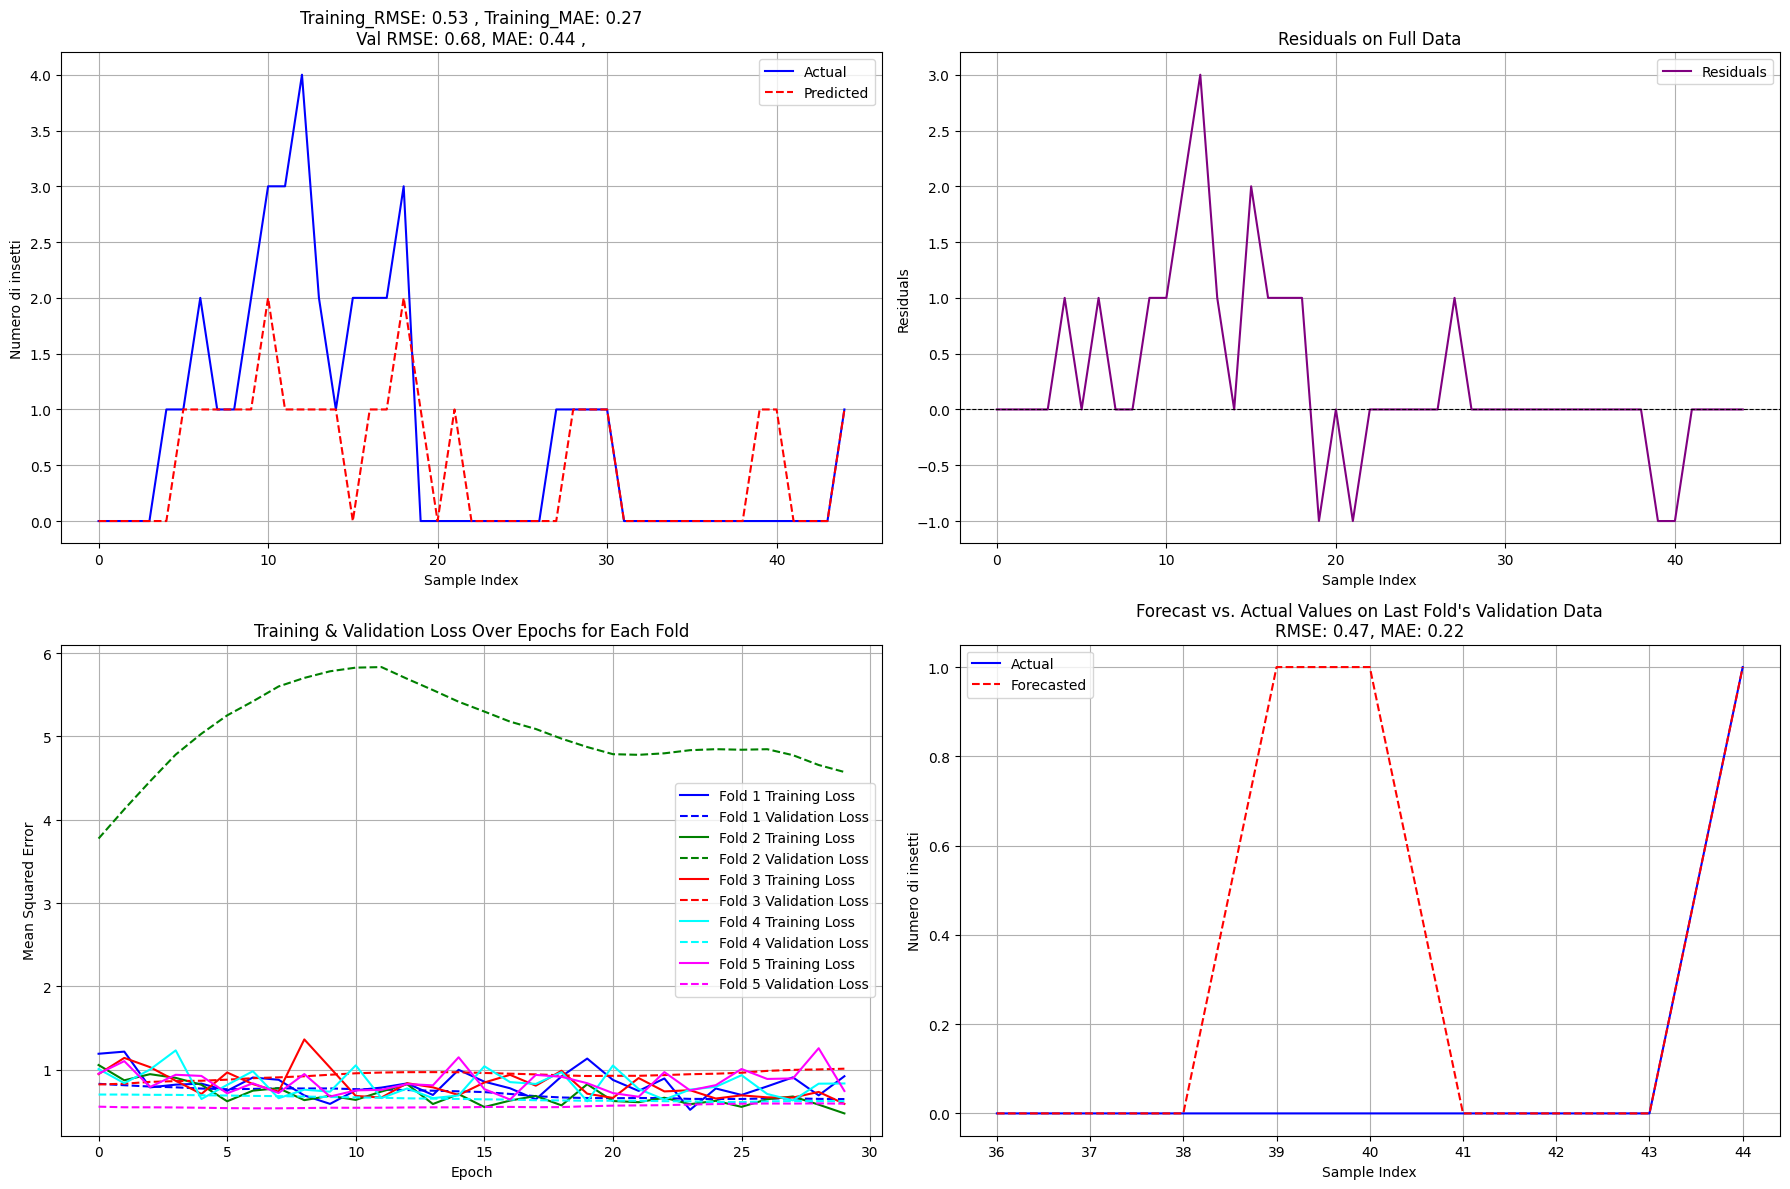

In [37]:
#@title Model Optimization: Cross Validation
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
# Assuming 'trained_model.h5' is your saved model file
#model_mlp = load_model('trained_mlp.keras')

model_mlp = load_model('best_model_mlp.keras', custom_objects={'mean_squared_error': 'mean_squared_error'})

#model_mlp = load_model('trained_mlp.h5')
model_mlp.compile(optimizer='adam', loss='mean_squared_error')


# Save the initial weights after loading
initial_weights = model_mlp.get_weights()


# Preprocessing and Creating Lagged Features
def create_lagged_features(df, n_lags=5, target_col='Numero di insetti', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna().reset_index(drop=True)
    return lagged_df

n_lags = 3
df_copia = df_finale_regressione.copy()
df_copia = df_features_drop.copy()
columns = df_copia.columns.tolist()
if 'Numero di insetti' in columns:
  columns.remove('Numero di insetti')
exog_cols = columns
# Create lagged features
lagged_df = create_lagged_features(df_copia, n_lags=n_lags, target_col='Numero di insetti', exog_cols=exog_cols)

# Define features and target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Numero di insetti']


# Prepare indices for plotting (after shuffling)
y_index = y.index

# Initialize arrays to store predictions
y_pred_full = np.zeros(len(y))
residuals_full = np.zeros(len(y))

# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=False)

fold = 1
histories = []
rmse_train_scores = []
mae_train_scores = []
rmse_val_scores = []
mae_val_scores = []

for train_index, val_index in kf.split(X):
    print(f"Fold {fold}")
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_val_scaled = scaler.transform(X_val_cv)

    # Reset the model weights and recompile
    model_mlp.set_weights(initial_weights)
    model_mlp.compile(optimizer='adam', loss=weighted_mse_loss)#'mean_squared_error')

    # Retrain the model
    history = model_mlp.fit(
        X_train_scaled, y_train_cv,
        epochs=30,
        batch_size=16,
        validation_data=(X_val_scaled, y_val_cv),
        verbose=0
    )

    histories.append(history)

    # Predictions on training and validation data
    y_train_pred = model_mlp.predict(X_train_scaled)
    y_val_pred = model_mlp.predict(X_val_scaled)

    # Post-processing
    y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
    y_val_pred_processed = np.clip(y_val_pred.flatten(), 0, None).round()

    # Store validation predictions
    y_pred_full[val_index] = y_val_pred_processed
    residuals_full[val_index] = y_val_cv - y_val_pred_processed

    # Calculate metrics
    rmse_train = np.sqrt(mean_squared_error(y_train_cv, y_train_pred_processed))
    mae_train = mean_absolute_error(y_train_cv, y_train_pred_processed)
    rmse_val = np.sqrt(mean_squared_error(y_val_cv, y_val_pred_processed))
    mae_val = mean_absolute_error(y_val_cv, y_val_pred_processed)

    rmse_train_scores.append(rmse_train)
    mae_train_scores.append(mae_train)
    rmse_val_scores.append(rmse_val)
    mae_val_scores.append(mae_val)

    print(f"Fold {fold} - Train RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Fold {fold} - Val RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}")

    fold += 1

# Compute average metrics
avg_rmse_train = np.mean(rmse_train_scores)
avg_mae_train = np.mean(mae_train_scores)
avg_rmse_val = np.mean(rmse_val_scores)
avg_mae_val = np.mean(mae_val_scores)

print(f"\nAverage Train RMSE: {avg_rmse_train:.2f}, MAE: {avg_mae_train:.2f}")
print(f"Average Validation RMSE: {avg_rmse_val:.2f}, MAE: {avg_mae_val:.2f}")

# Plotting the results in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Actual vs. Predicted Values on Full Data
axs[0, 0].plot(y_index, y, label='Actual', color='blue', linestyle='-')
axs[0, 0].plot(y_index, y_pred_full, label='Predicted', color='red', linestyle='--')
axs[0, 0].set_title(f'Training_RMSE: {avg_rmse_train:.2f} , Training_MAE: {avg_mae_train:.2f}\n Val RMSE: {avg_rmse_val:.2f}, MAE: {avg_mae_val:.2f} , ')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Numero di insetti')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residuals on Full Data
axs[0, 1].plot(y_index, residuals_full, label='Residuals', color='purple', linestyle='-')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Full Data')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Training & Validation Loss Over Epochs for Each Fold
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i, history in enumerate(histories):
    axs[1, 0].plot(history.history['loss'], label=f'Fold {i+1} Training Loss', color=colors[i], linestyle='-')
    axs[1, 0].plot(history.history['val_loss'], label=f'Fold {i+1} Validation Loss', color=colors[i], linestyle='--')
axs[1, 0].set_title('Training & Validation Loss Over Epochs for Each Fold')
axs[1, 0].set_ylabel('Mean Squared Error')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Forecast vs. Actual Values on Test Data (Last Fold's Validation Set)
axs[1, 1].plot(y_val_cv.index, y_val_cv.values, label='Actual', color='blue', linestyle='-')
axs[1, 1].plot(y_val_cv.index, y_val_pred_processed, label='Forecasted', color='red', linestyle='--')
axs[1, 1].set_title(f'Forecast vs. Actual Values on Last Fold\'s Validation Data\nRMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Numero di insetti')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


#Uncertainty Quantification (Optional)

In [38]:
pip install quantile-forest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.5 MB/s eta 0:00:00


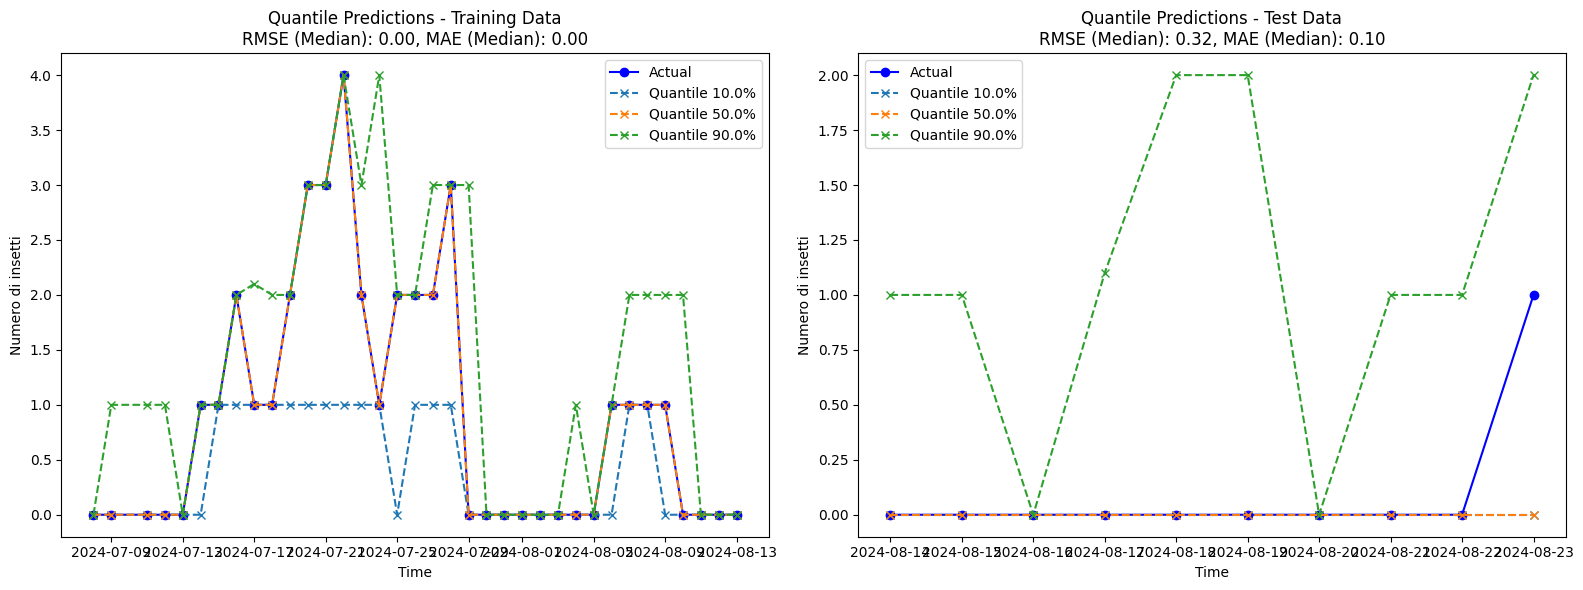

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from quantile_forest import RandomForestQuantileRegressor

# Funzione per creare le feature lagged
def create_lagged_features(df, n_lags=7, target_col='Numero di insetti', exog_cols=[]):
    """ Create lagged features for the target and use exogenous columns as is. """
    # Create lagged features for the target column only
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

def train_and_predict_quantiles(df, n_lags, exog_cols, target_col, quantiles=[0.1, 0.5, 0.9]):
    """ Train QRForest and calculate quantile predictions (10th, 50th, and 90th). """
    df = create_lagged_features(df, n_lags=n_lags, exog_cols=exog_cols)

    # Use only lagged features of the target and direct use of exogenous columns
    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = df[feature_cols]
    y = df[target_col]

    # Chronological Split of Data
    train_size = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train QRForest model
    qr_forest_model = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, random_state=42)
    qr_forest_model.fit(X_train_scaled, y_train)

    # Predict quantiles from the model
    train_quantiles = qr_forest_model.predict(X_train_scaled, quantiles=quantiles)
    test_quantiles = qr_forest_model.predict(X_test_scaled, quantiles=quantiles)

    # Calcolare il RMSE e MAE usando il quantile mediano (50th quantile)
    median_train_pred = train_quantiles[:, 1]  # 50th quantile prediction (median)
    median_test_pred = test_quantiles[:, 1]  # 50th quantile prediction (median)

    # Calcolare RMSE e MAE per il train set
    rmse_train = np.sqrt(np.mean((y_train - median_train_pred)**2))
    mae_train = np.mean(np.abs(y_train - median_train_pred))

    # Calcolare RMSE e MAE per il test set
    rmse_test = np.sqrt(np.mean((y_test - median_test_pred)**2))
    mae_test = np.mean(np.abs(y_test - median_test_pred))

    # Plot the quantiles for train and test data
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Actual vs. Quantile Prediction on Training Data
    axs[0].plot(y_train.index, y_train, label='Actual', marker='o', color='blue')
    for i, quantile in enumerate(quantiles):
        axs[0].plot(y_train.index, train_quantiles[:, i], label=f'Quantile {quantile * 100}%', linestyle='--', marker='x')
    axs[0].set_title(f'Quantile Predictions - Training Data\nRMSE (Median): {rmse_train:.2f}, MAE (Median): {mae_train:.2f}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Numero di insetti')
    axs[0].legend()

    # Actual vs. Quantile Prediction on Test Data
    axs[1].plot(y_test.index, y_test, label='Actual', marker='o', color='blue')
    for i, quantile in enumerate(quantiles):
        axs[1].plot(y_test.index, test_quantiles[:, i], label=f'Quantile {quantile * 100}%', linestyle='--', marker='x')
    axs[1].set_title(f'Quantile Predictions - Test Data\nRMSE (Median): {rmse_test:.2f}, MAE (Median): {mae_test:.2f}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Numero di insetti')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return qr_forest_model, df

# Assuming df is your DataFrame and contains the necessary data
df_copia = df_finale_regressione.copy()
df_copia = df.copy()
df_copia = df_features_drop.copy()
Columns = df_copia.columns.tolist()
if 'Numero di insetti' in Columns:
    Columns.remove('Numero di insetti')
Variabili_esogene = Columns

# Train QRForest model with Quantile regression (e.g., [0.1, 0.5, 0.9])
qr_forest_model, real_data = train_and_predict_quantiles(df_copia, n_lags=2, exog_cols=Variabili_esogene, target_col='Numero di insetti', quantiles=[0.1, 0.5, 0.9])


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,683 (14.39 KB)

 Trainable params: 3,555 (13.89 KB)

 Non-trainable params: 128 (512.00 B)


Epoch 1: val_loss improved from inf to 0.09437, saving model to best_model_quintile.keras

Epoch 2: val_loss improved from 0.09437 to 0.08568, saving model to best_model_quintile.keras

Epoch 3: val_loss improved from 0.08568 to 0.08258, saving model to best_model_quintile.keras

Epoch 4: val_loss did not improve from 0.08258

Epoch 5: val_loss did not improve from 0.08258

Epoch 6: val_loss did not improve from 0.08258

Epoch 7: val_loss did not improve from 0.08258

Epoch 8: val_loss improved from 0.08258 to 0.08220, saving model to best_model_quintile.keras

Epoch 9: val_loss improved from 0.08220 to 0.08104, saving model to best_model_quintile.keras

Epoch 10: val_loss did not improve from 0.08104

Epoch 11: val_loss did not improve from 0.08104

Epoch 12: val_loss did not improve from 0.08104

Epoch 13: val_loss did not improve from 0.08104

Epoch 14: val_loss did not improve from 0.08104

Epoch 15: val_loss did not improve from 0.08104

Epoch 16: val_loss did not improve from 0.

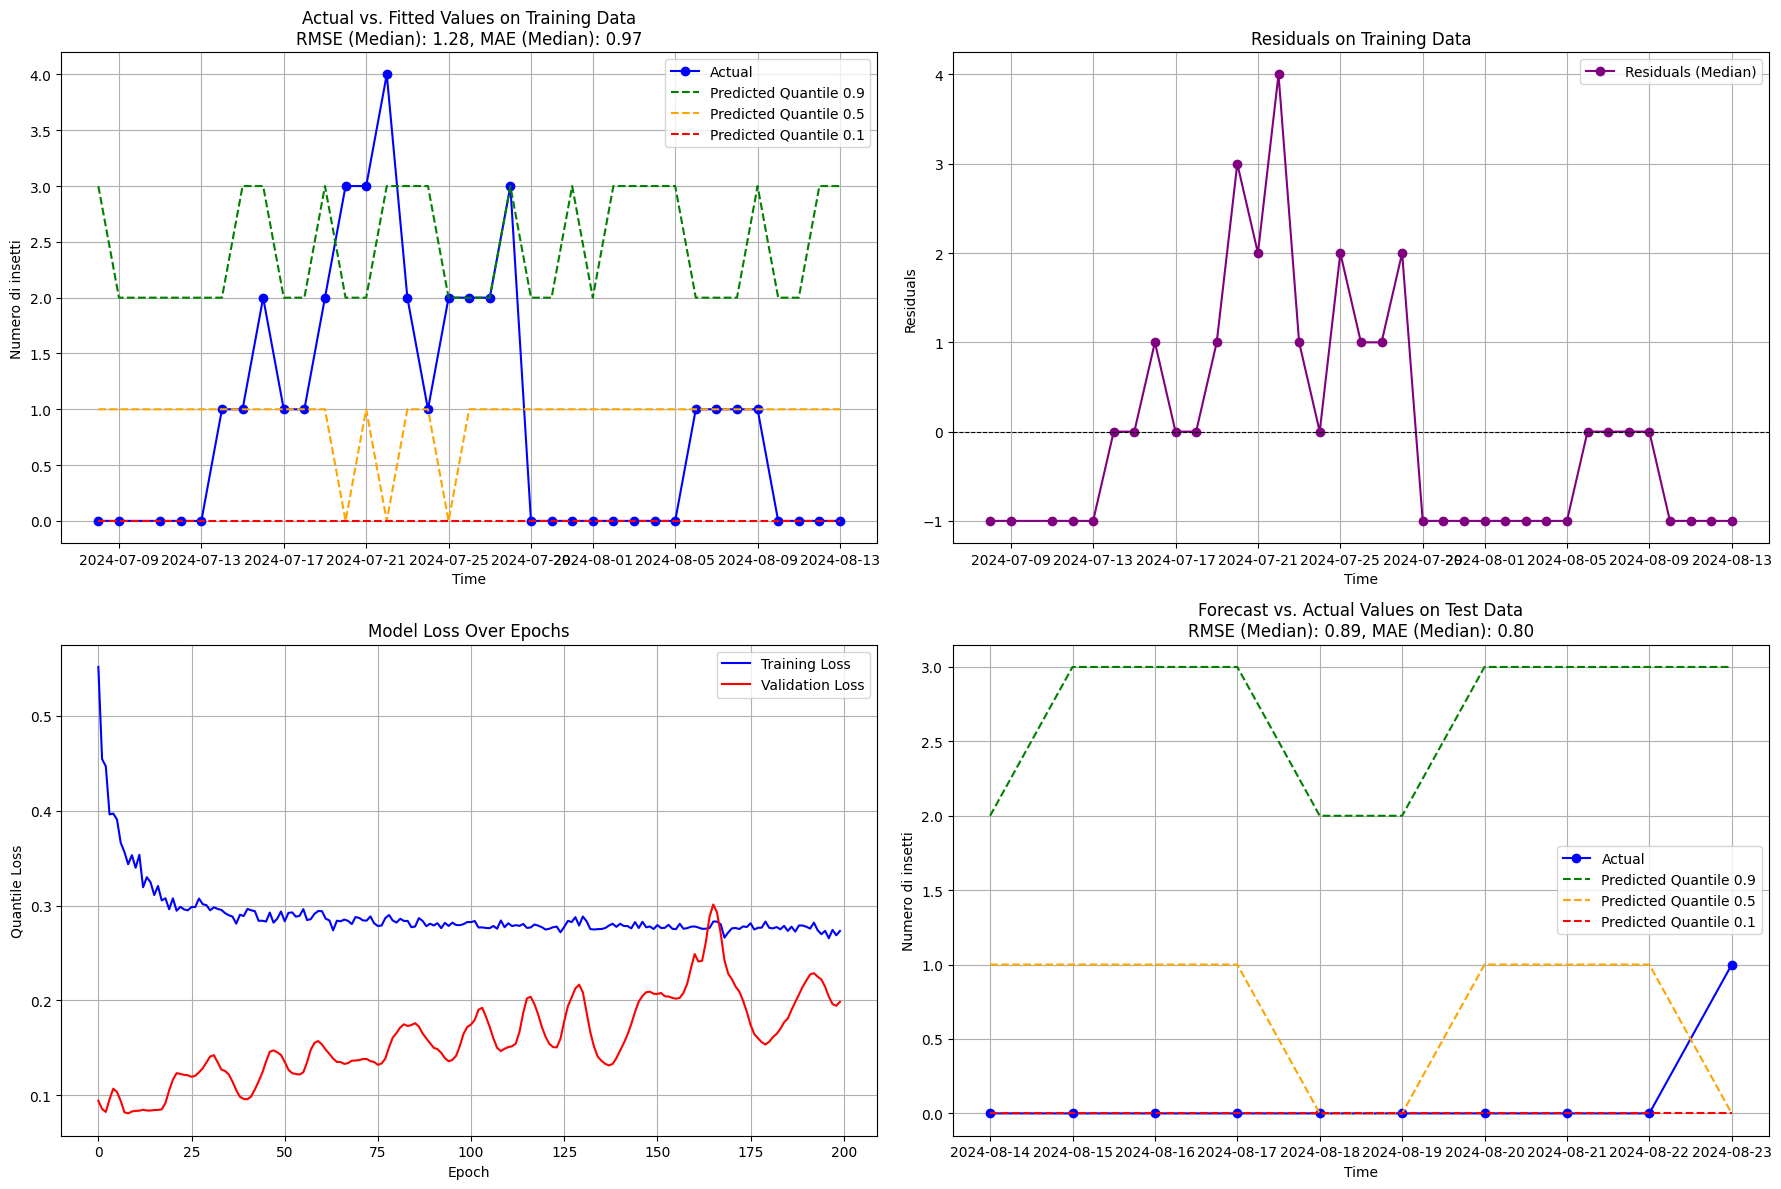

In [44]:
#@title Advanced Topics: Uncertainty Quantification

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Preprocessing and Creating Lagged Features
def create_lagged_features(df, n_lags=2, target_col='Numero di insetti', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna()
    return lagged_df

n_lags = 2  # Number of lags
df_copia = df_features_drop.copy()

columns = df_copia.columns.tolist()
if 'Numero di insetti' in columns:
  columns.remove('Numero di insetti')
exog_cols = columns
# Create lagged features including exogenous variables
lagged_df = create_lagged_features(df_copia, n_lags=n_lags, target_col='Numero di insetti', exog_cols=exog_cols)

# Define features and target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Numero di insetti']

# Prepare the features and target
variables = ['Numero di insetti'] + exog_cols

# Prepare lists of columns per timestep
timestep_cols = []
for t in range(n_lags):
    lag = n_lags - t
    cols = [f'{var}_lag_{lag}' for var in variables]
    timestep_cols.append(cols)

# Define features and target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Numero di insetti']

# Splitting Data into training and test sets
train_size = int(len(lagged_df) * 0.8)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Quantiles
quantiles = [0.9,  0.5,   0.1]

'''
# Define the Quantile Loss Function with weighted loss based on y_pred
def multi_quantile_loss(quantiles):
    def loss(y_true, y_pred):
        y_true_expanded = tf.expand_dims(y_true, -1)  # Expand y_true to match y_pred shape
        e = y_true_expanded - y_pred

        # Create a mask where y_pred is 0 (weight 1) or non-zero (weight 2)
        weight_mask = tf.where(tf.equal(y_pred, 0.0), 1.0, 2.0)  # If y_pred is 0, weight is 1, else 2

        # Apply quantile loss formula with weighted loss
        qs = tf.constant(quantiles, dtype=tf.float32, shape=[1, len(quantiles)])
        weighted_loss = tf.reduce_mean(weight_mask * tf.maximum(qs * e, (qs - 1) * e))

        return weighted_loss

    return loss

'''

# Define the Quantile Loss Function
def multi_quantile_loss(quantiles):
    def loss(y_true, y_pred):
        y_true_expanded = tf.expand_dims(y_true, -1)  # Expand y_true to match y_pred shape
        e = y_true_expanded - y_pred
        qs = tf.constant(quantiles, dtype=tf.float32, shape=[1, len(quantiles)])
        loss = tf.reduce_mean(tf.maximum(qs * e, (qs - 1) * e))
        return loss
    return loss

# Define a complex MLP Model with Multiple Outputs for Quantiles
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization layer for normalizing activations
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),  # Another Dropout layer
    tf.keras.layers.Dense(len(quantiles), activation='linear')  # Output layer for multiple quantiles
])


# Setup a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.015,  # Start with a higher learning rate
    decay_steps=1000,
    decay_rate=0.96,  # Smaller decay rate for a more gradual decrease
    staircase=True)

# Compile the model using Adam optimizer with a learning rate schedule
model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=multi_quantile_loss(quantiles))

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='best_model_quintile.keras',  # File where the model is saved
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model
    mode='min',               # Minimize the loss
    verbose=1                 # Print info when the model is saved
)

# Model summary to display architecture
model_mlp.summary()
# Train the Model
history = model_mlp.fit(
    X_train_scaled, y_train,
    epochs=200,  # Increased epochs for more complex model
    batch_size=32,  # Adjusted batch size
    validation_data=(X_test_scaled, y_test),
    callbacks=[checkpoint],    # Add the ModelCheckpoint callback
    verbose=0
)

best_model_quintile = load_model('best_model_quintile.keras', custom_objects={'loss': multi_quantile_loss(quantiles)})


# Predictions on training and test data
y_train_pred = model_mlp.predict(X_train_scaled)
y_test_pred = model_mlp.predict(X_test_scaled)

# Round predictions immediately for display and evaluation
y_train_pred_processed = np.clip(y_train_pred, 0, None).round()
y_test_pred_processed = np.clip(y_test_pred, 0, None).round()

# Index for the median (0.5 quantile)
median_index = quantiles.index(0.5)

# Calculate RMSE and MAE on training data using the median prediction
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_processed[:, median_index]))
mae_train = mean_absolute_error(y_train, y_train_pred_processed[:, median_index])

# Calculate RMSE and MAE on test data using the median prediction
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_processed[:, median_index]))
mae_test = mean_absolute_error(y_test, y_test_pred_processed[:, median_index])

# Residuals on training data
residuals_train = y_train - y_train_pred_processed[:, median_index]

# Prepare indices for plotting
y_train_index = lagged_df.index[:train_size]
y_test_index = lagged_df.index[train_size:]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Actual vs. Fitted Values on Training Data with Quantiles
axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')

# Plot all quantile predictions
colors = ['green', 'orange', 'red', 'purple', 'brown']
for idx, q in enumerate(quantiles):
    axs[0, 0].plot(y_train_index, y_train_pred_processed[:, idx], label=f'Predicted Quantile {q}', linestyle='--', color=colors[idx])

axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE (Median): {rmse_train:.2f}, MAE (Median): {mae_train:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Numero di insetti')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residuals on Training Data (using median prediction)
axs[0, 1].plot(y_train_index, residuals_train, label='Residuals (Median)', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Training & Validation Loss Over Epochs
axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Quantile Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Forecast vs. Actual Values on Test Data with Quantiles
axs[1, 1].plot(y_test_index, y_test, label='Actual', marker='o', color='blue')

# Plot all quantile predictions
for idx, q in enumerate(quantiles):
    axs[1, 1].plot(y_test_index, y_test_pred_processed[:, idx], label=f'Predicted Quantile {q}', linestyle='--', color=colors[idx])

axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE (Median): {rmse_test:.2f}, MAE (Median): {mae_test:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Numero di insetti')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

